# Práctica Aprendizaje Automático - Predicción de abandono corporativo
Joaquín Loaces | Prof. Pedro Isasi | Prof. Alejandro Baldominos | Máster en Inteligencia Artificial Aplicada | UC3M

# Importamos las librerías necesarias

In [ ]:
pip install -U imbalanced-learn


In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier


import warnings

La siguiente línea de código evita que se muestren warnings en problemas de convergencia.

In [ ]:
warnings.filterwarnings(action='ignore')

# Importamos del conjunto de datos

In [ ]:
# Montar tu Drive
drive.mount('/content/drive')

# Ruta al archivo (ajustá la carpeta según dónde lo tengas en tu Drive)
path = '/content/drive/MyDrive/MASTER/ML/train.csv'

# Leer el CSV
df = pd.read_csv(path)
df.head()



Mounted at /content/drive


,ID,Age,Gender,Marital Status,Education Field,Education Level,Miles from Home to Work,Department Name,Job Role Name,Job Level,...,Work Life Balance Satisfaction,Last Salary Increase (%),Amount of Stock Option,Number of Training Sessions Last Year,Number of Other Companies,Total Active Years,Years at Current Company,Years Since Last Promotion,Years with Current Manager,Attrition
0,1,38,Male,Married,Life Sciences,College,11.0,Research & Development,Sales Executive,Entry Level,...,2.0,11,Low,3,7.0,7.0,0,0,0,No
1,2,45,Female,NaN,Human Resources,Bachelor,14.0,Human Resources,Sales Executive,Entry Level,...,4.0,13,NaN,3,4.0,17.0,0,0,0,No
2,3,29,Male,Single,Life Sciences,Doctor,3.0,Human Resources,Sales Executive,Entry Level,...,3.0,11,Low,2,6.0,3.0,0,0,0,Yes
3,4,44,Male,Single,Life Sciences,Bachelor,20.0,Research & Development,Sales Representative,Entry Level,...,3.0,13,NaN,4,2.0,6.0,0,0,0,No
4,5,21,Male,Single,Life Sciences,Bachelor,2.0,Sales,Manufacturing Director,Mid Level,...,3.0,12,Low,3,1.0,0.0,0,0,0,No


In [ ]:
# Elimino la variable ID ya que no aporta información valiosa
df = df.drop(columns=['ID'])

# Breve análisis de la estructura de los datos

In [ ]:
# Analizamos las dimensiones del dataset
df.shape

(3528, 26)

In [ ]:
# Analizamos los tipos de datos y la proporcion que tiene cada variable de missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3528 entries, 0 to 3527
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    3528 non-null   int64  
 1   Gender                                 3528 non-null   object 
 2   Marital Status                         3009 non-null   object 
 3   Education Field                        3528 non-null   object 
 4   Education Level                        3528 non-null   object 
 5   Miles from Home to Work                2815 non-null   float64
 6   Department Name                        3528 non-null   object 
 7   Job Role Name                          3528 non-null   object 
 8   Job Level                              3528 non-null   object 
 9   Business Travel Frequency              3528 non-null   object 
 10  Yearly Income                          3528 non-null   int64  
 11  Abse

In [ ]:
# Se observan las columnas con missing values y su proporción sobre el total de observaciones
missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]
missing_table = pd.DataFrame({
    'MissingCount': missing_values,
    'MissingPercent (%)': (missing_values / len(df)) * 100
}).sort_values(by='MissingPercent (%)', ascending=False)
missing_table

,MissingCount,MissingPercent (%)
Amount of Stock Option,1501,42.545351
Miles from Home to Work,713,20.209751
Marital Status,519,14.710884
Work Life Balance Satisfaction,203,5.753968
Job Satisfaction,189,5.357143
Environment Satisfaction,177,5.017007
Number of Other Companies,14,0.396825
Total Active Years,7,0.198413


### Particularidad: Missing Values en la columna Amount of Stock Option
Esta columna presenta 1.501 missing values que, en realidad, no se corresponden a missing values sino a que en el dataset original el valor "None" es una categoría más, tal como "Low", "Medium" o "High". Sin embargo, al leer el archivo, `pandas` lo interpreta como un nulo y asigna `NaN`, por lo que en el pipeline será sustituído específicamente por el string original "None".

In [ ]:
df['Amount of Stock Option']

,Amount of Stock Option
0,Low
1,NaN
2,Low
3,NaN
4,Low
...,...
3523,NaN
3524,NaN
3525,NaN
3526,NaN


In [ ]:
# Resumen estadístico
df.describe()

,Age,Miles from Home to Work,Yearly Income,Absences per Year,Performance Rating,Job Satisfaction,Environment Satisfaction,Work Life Balance Satisfaction,Last Salary Increase (%),Number of Training Sessions Last Year,Number of Other Companies,Total Active Years,Years at Current Company,Years Since Last Promotion,Years with Current Manager
count,3528.000000,2815.000000,3528.000000,3528.000000,3528.000000,3339.000000,3351.000000,3325.000000,3528.000000,3528.000000,3514.00000,3521.000000,3528.000000,3528.000000,3528.000000
mean,36.827381,9.124689,64534.906463,12.721655,3.154478,2.724468,2.720979,2.761805,15.221939,2.788549,2.69152,11.229480,7.006519,2.176587,4.108844
std,9.107988,8.074881,46623.464899,5.483554,0.361458,1.099391,1.091639,0.703556,3.663985,1.281508,2.51019,7.779683,6.125584,3.205599,3.555793
min,18.000000,1.000000,10090.000000,1.000000,3.000000,1.000000,1.000000,1.000000,11.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,28990.000000,8.000000,3.000000,2.000000,2.000000,2.000000,12.000000,2.000000,1.00000,6.000000,3.000000,0.000000,2.000000
50%,35.000000,7.000000,49000.000000,13.000000,3.000000,3.000000,3.000000,3.000000,14.000000,3.000000,2.00000,10.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,82447.500000,17.000000,3.000000,4.000000,4.000000,3.000000,18.000000,3.000000,4.00000,15.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,199990.000000,24.000000,4.000000,4.000000,4.000000,4.000000,25.000000,6.000000,9.00000,40.000000,40.000000,15.000000,17.000000


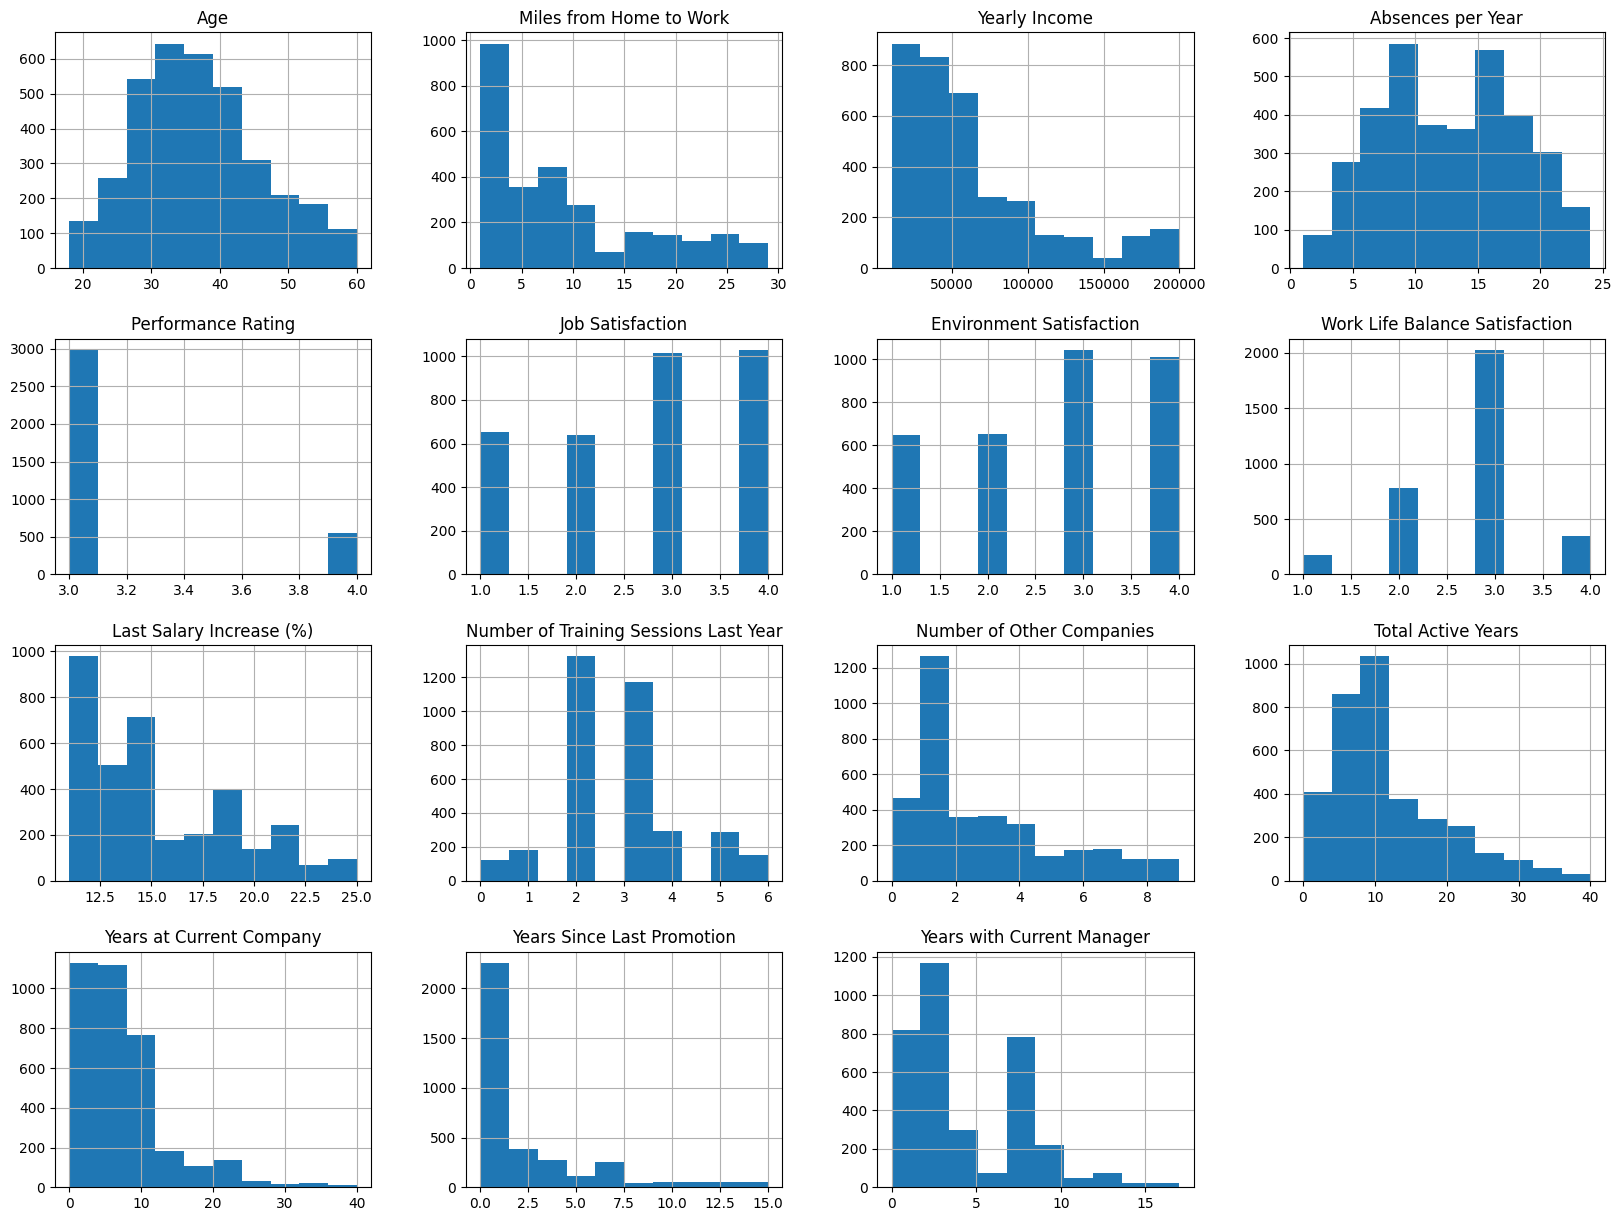

In [ ]:
# Se observan visualmente las distribuciones de las variables numéricas
df.hist(bins=10, figsize=(20,15))
plt.show()


Ahora se observarán las distribuciones de las variables numéricas pero discriminadas según la variable `Attrition`, con el objetivo de observar gráficamente si existen diferencias en la distribución de las variables según qué clase sea `Attrition`.

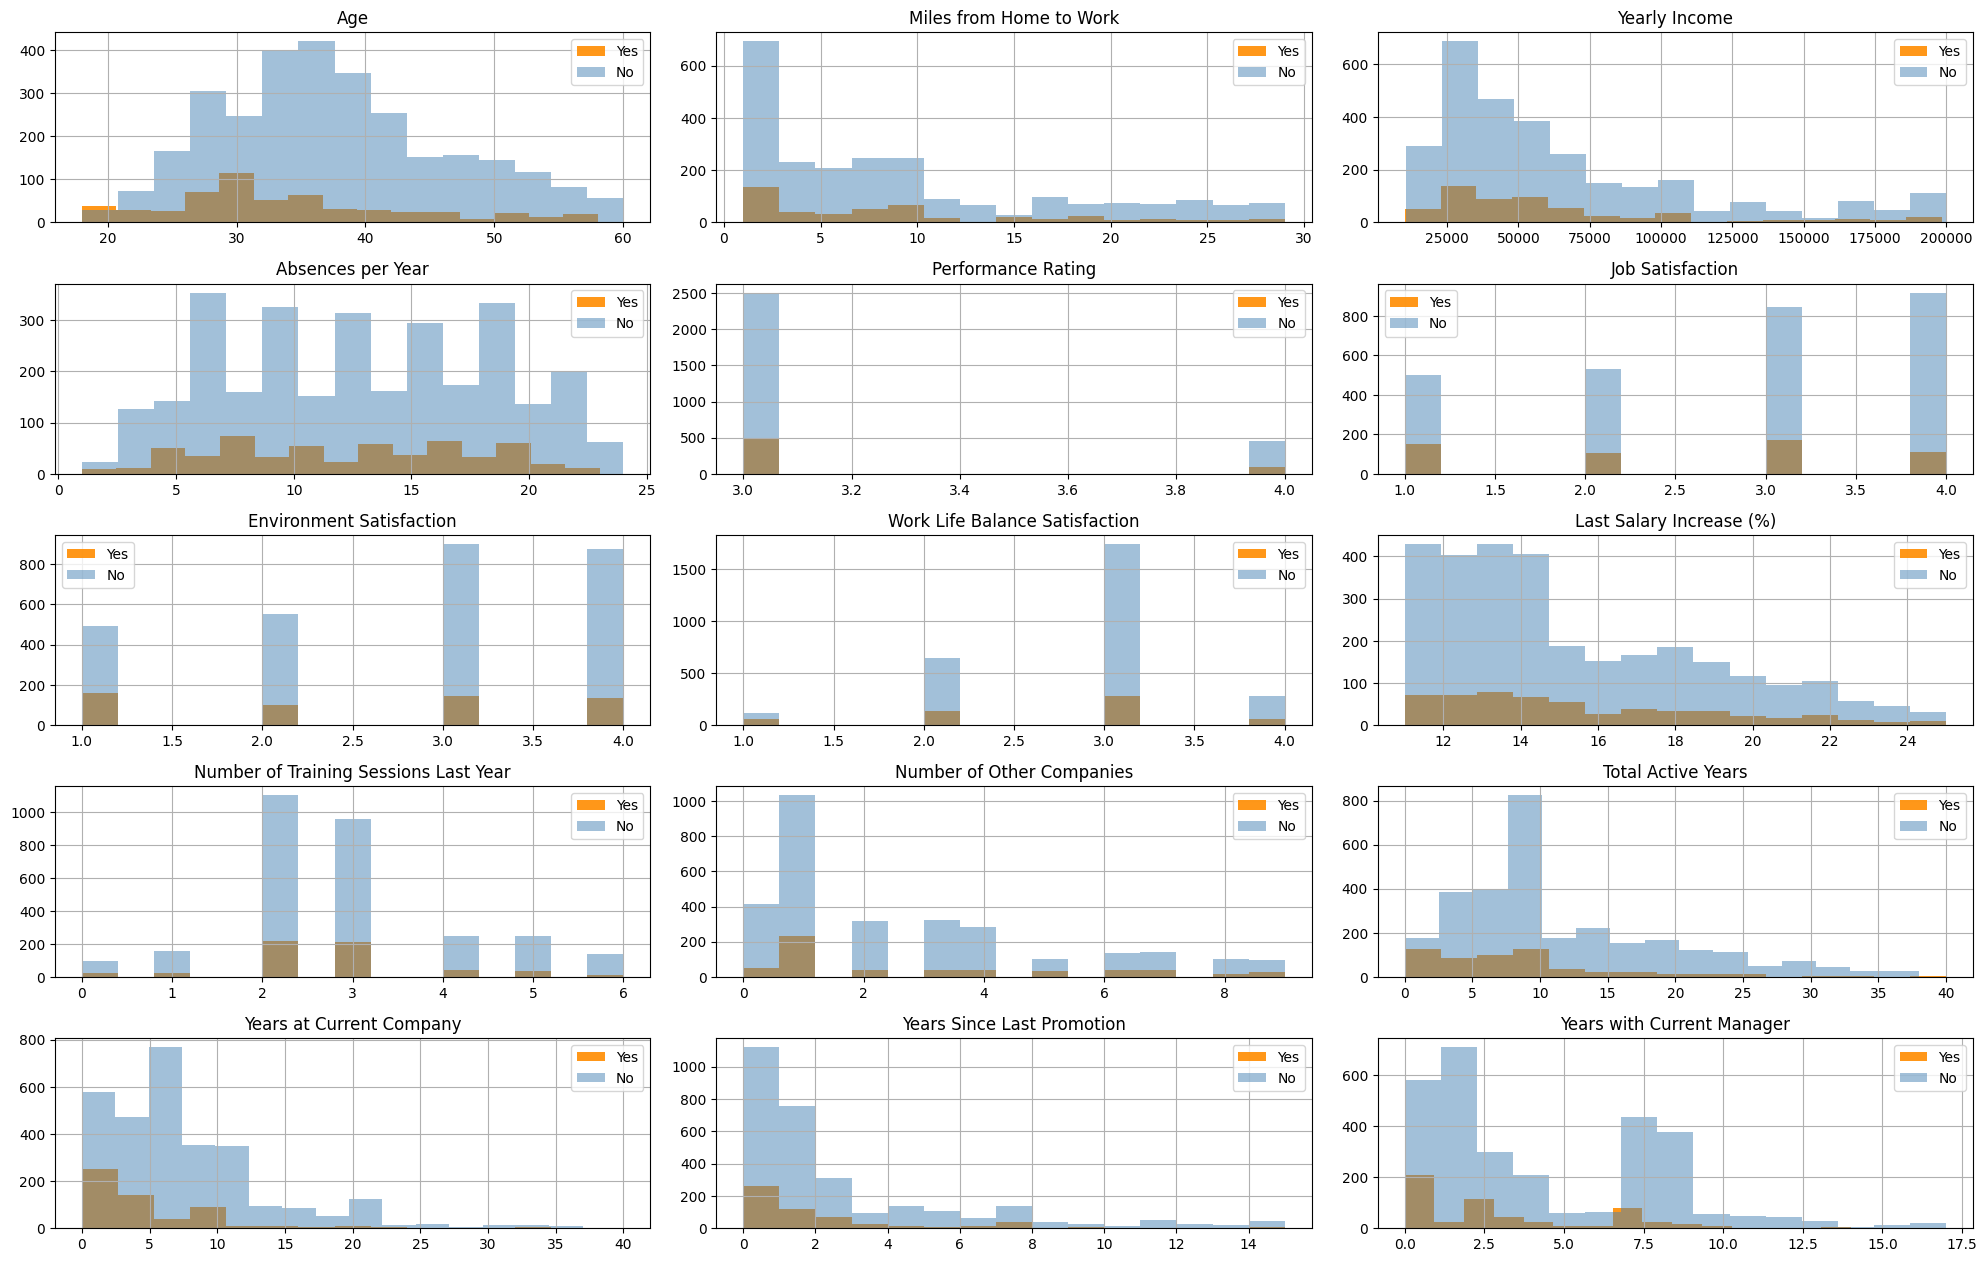

In [ ]:
# Se filtran solo las columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Se crean los subplots
fig, axes = plt.subplots(nrows=len(numeric_cols)//3 + 1, ncols=3, figsize=(20, 15))
axes = axes.flatten()

# Colores y transparencias por clase
style = {
    'Yes': {'color': 'darkorange', 'alpha': 0.9},
    'No':  {'color': 'steelblue',  'alpha': 0.5}
}

# Se generan los histogramas por variable
for i, col in enumerate(numeric_cols):
    for attrition_class, params in style.items():
        df[df['Attrition'] == attrition_class][col].hist(
            bins=15,
            ax=axes[i],
            label=attrition_class,
            **params
        )
    axes[i].set_title(col, fontsize=12)
    axes[i].legend()

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Las distribuciones no difieren prácticamente entre las clases de `Attrition`, lo que sugiere que no sería necesario una consideración especial en este caso. A continuación, se analizarán las distintas correlaciones entre las variables numéricas para un mejor panorama sobre su estructura.

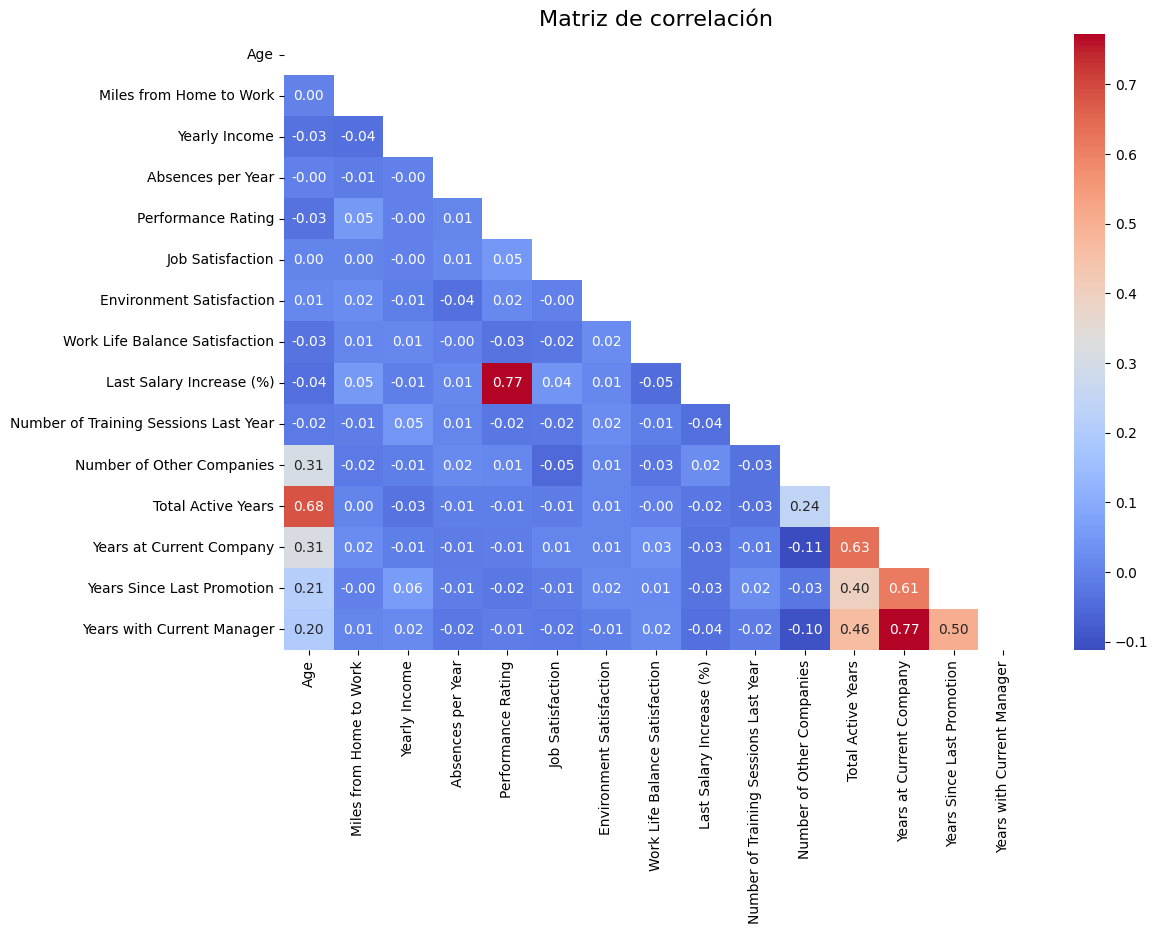

In [ ]:
corr = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'], errors='ignore').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlación", fontsize=16)
plt.show()


Se puede observar que, con excepciones puntuales, no existen correlaciones significativamente fuertes entre las variables numéricas, en la amplia mayoría de los casos, lo que favorece el posterior entrenamiento de algoritmos de Machine Learning. A continuación, se realizará un análisis similar pero para las variables categóricas.

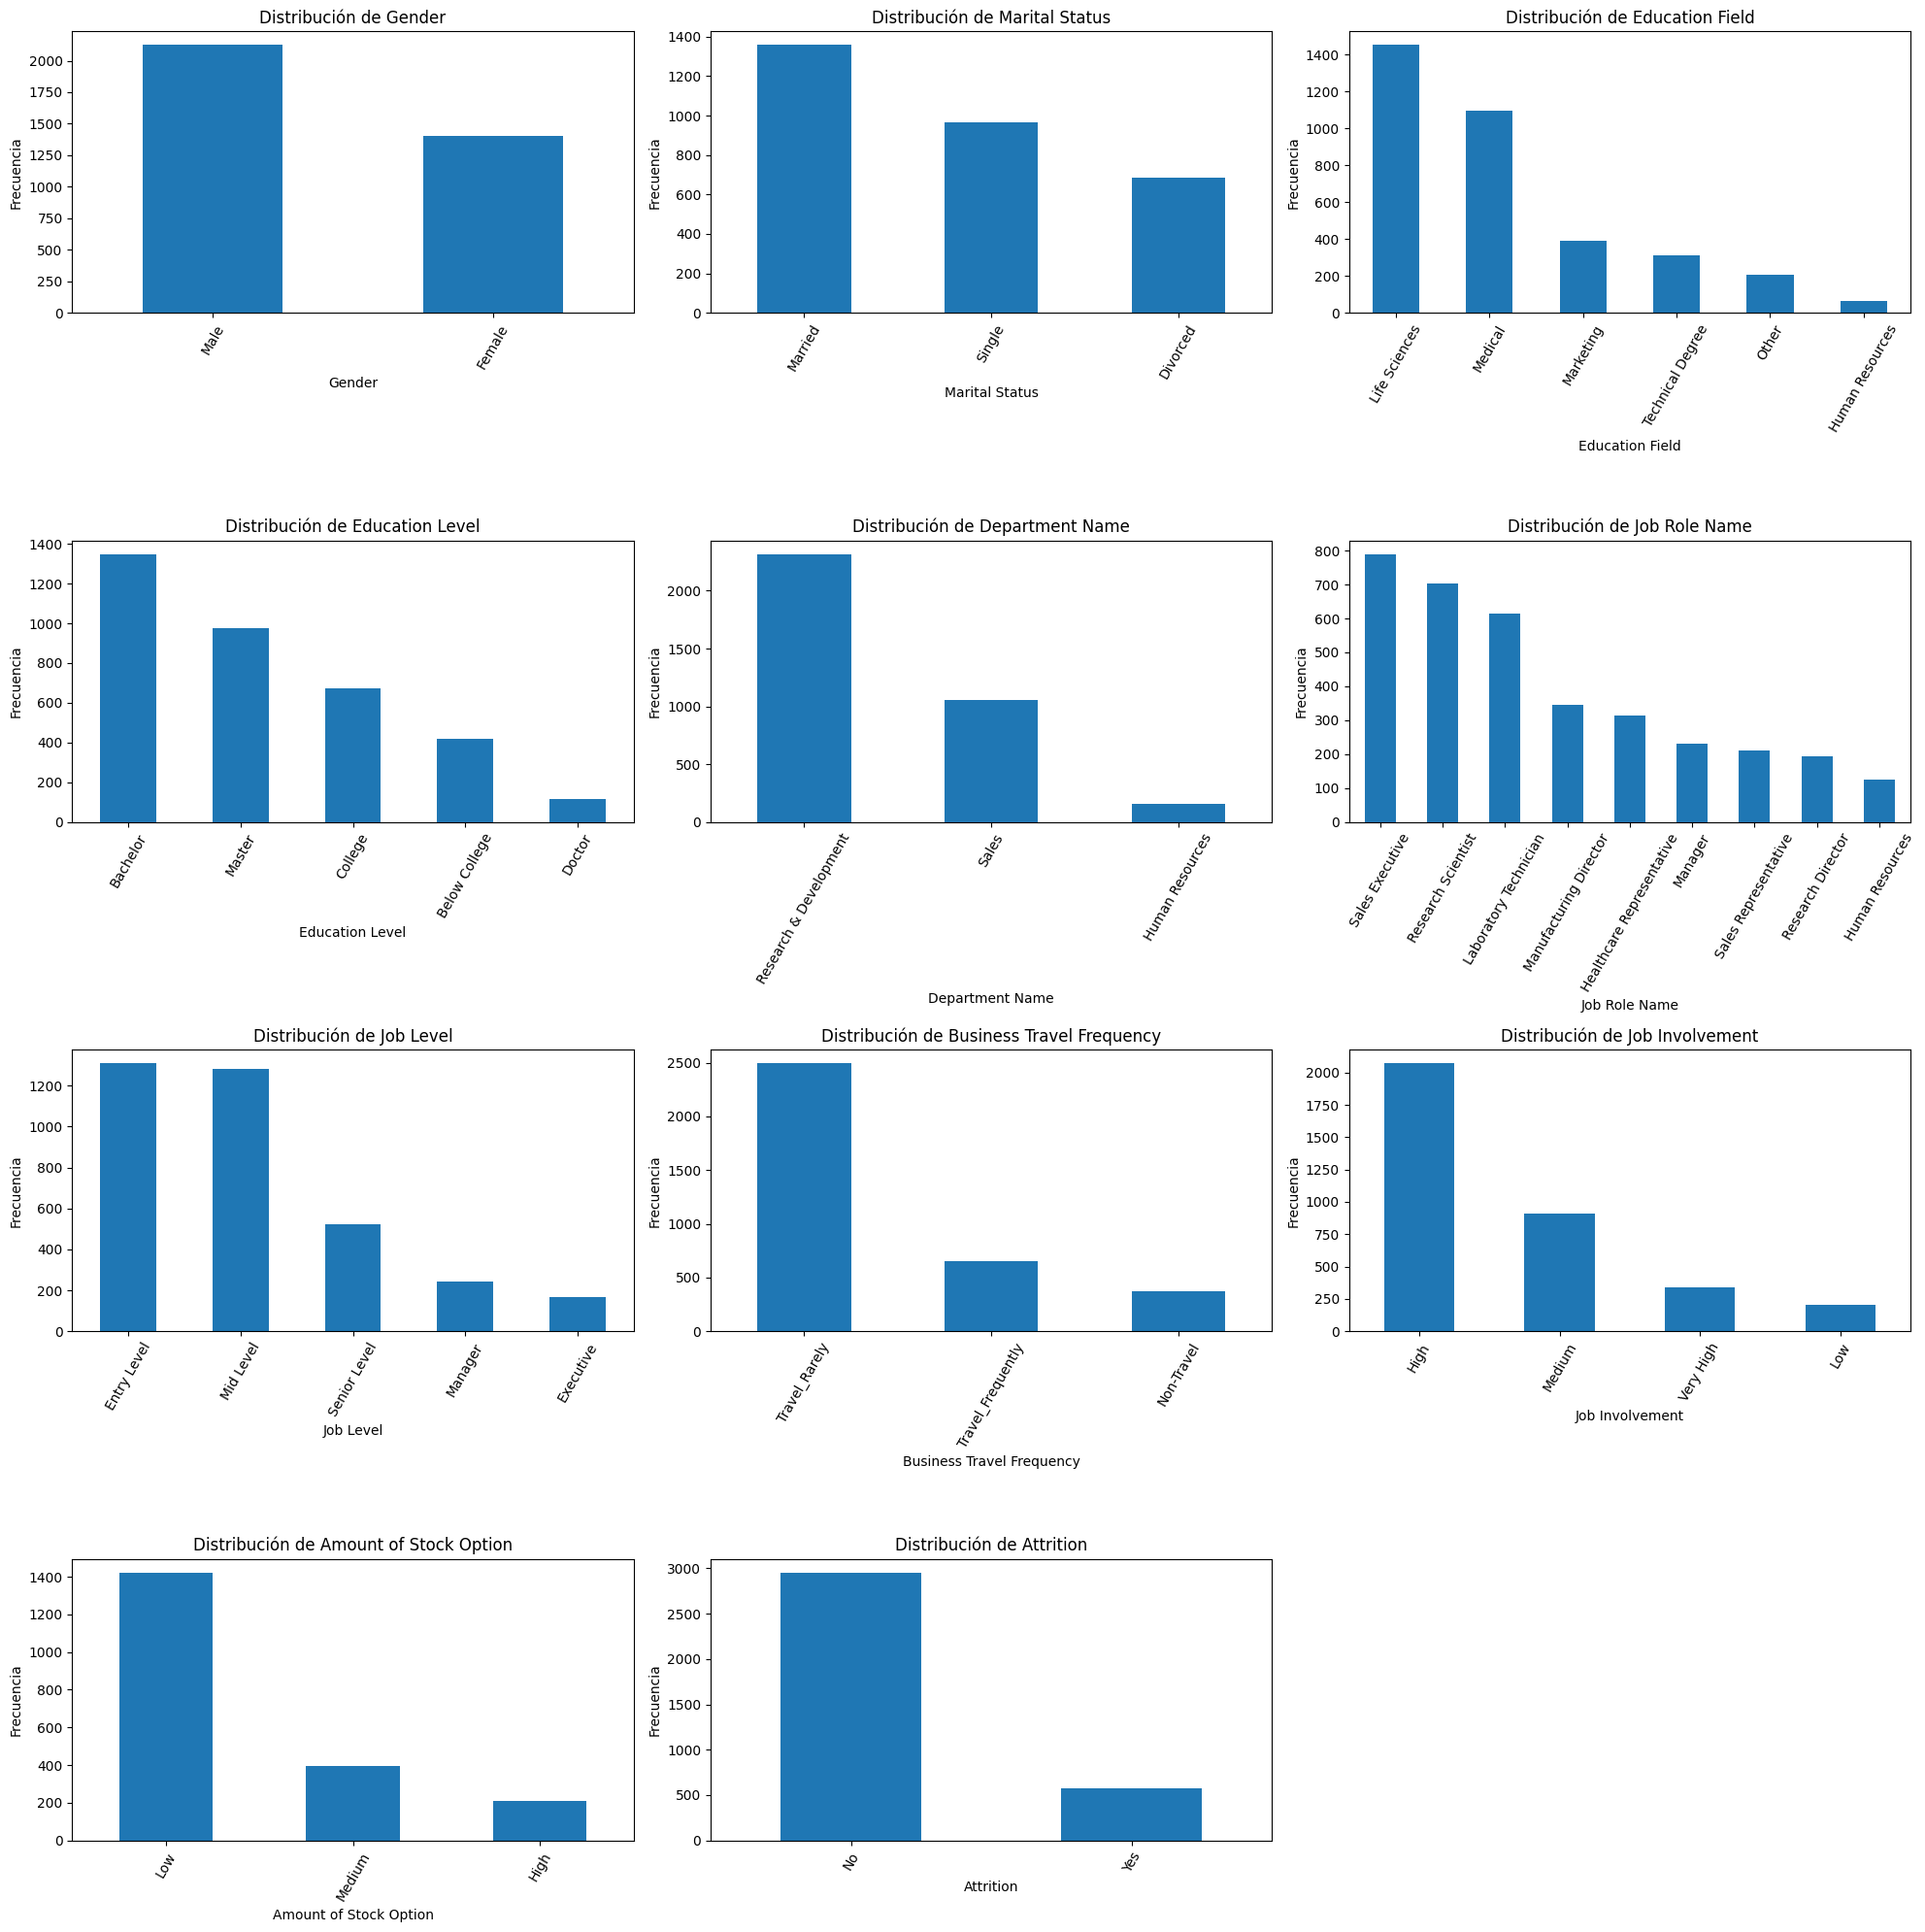

In [ ]:
# Detectar variables categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns

n = len(cat_cols)
rows = math.ceil(n / 3)  # 3 gráficos por fila

fig, axes = plt.subplots(rows, 3, figsize=(20, 5*rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis="x", rotation=60)

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Se realizará el mismo procedimiento que con las variables numéricas, analizando las distribuciones de las variables categóricas según la clase de `Attrition`.

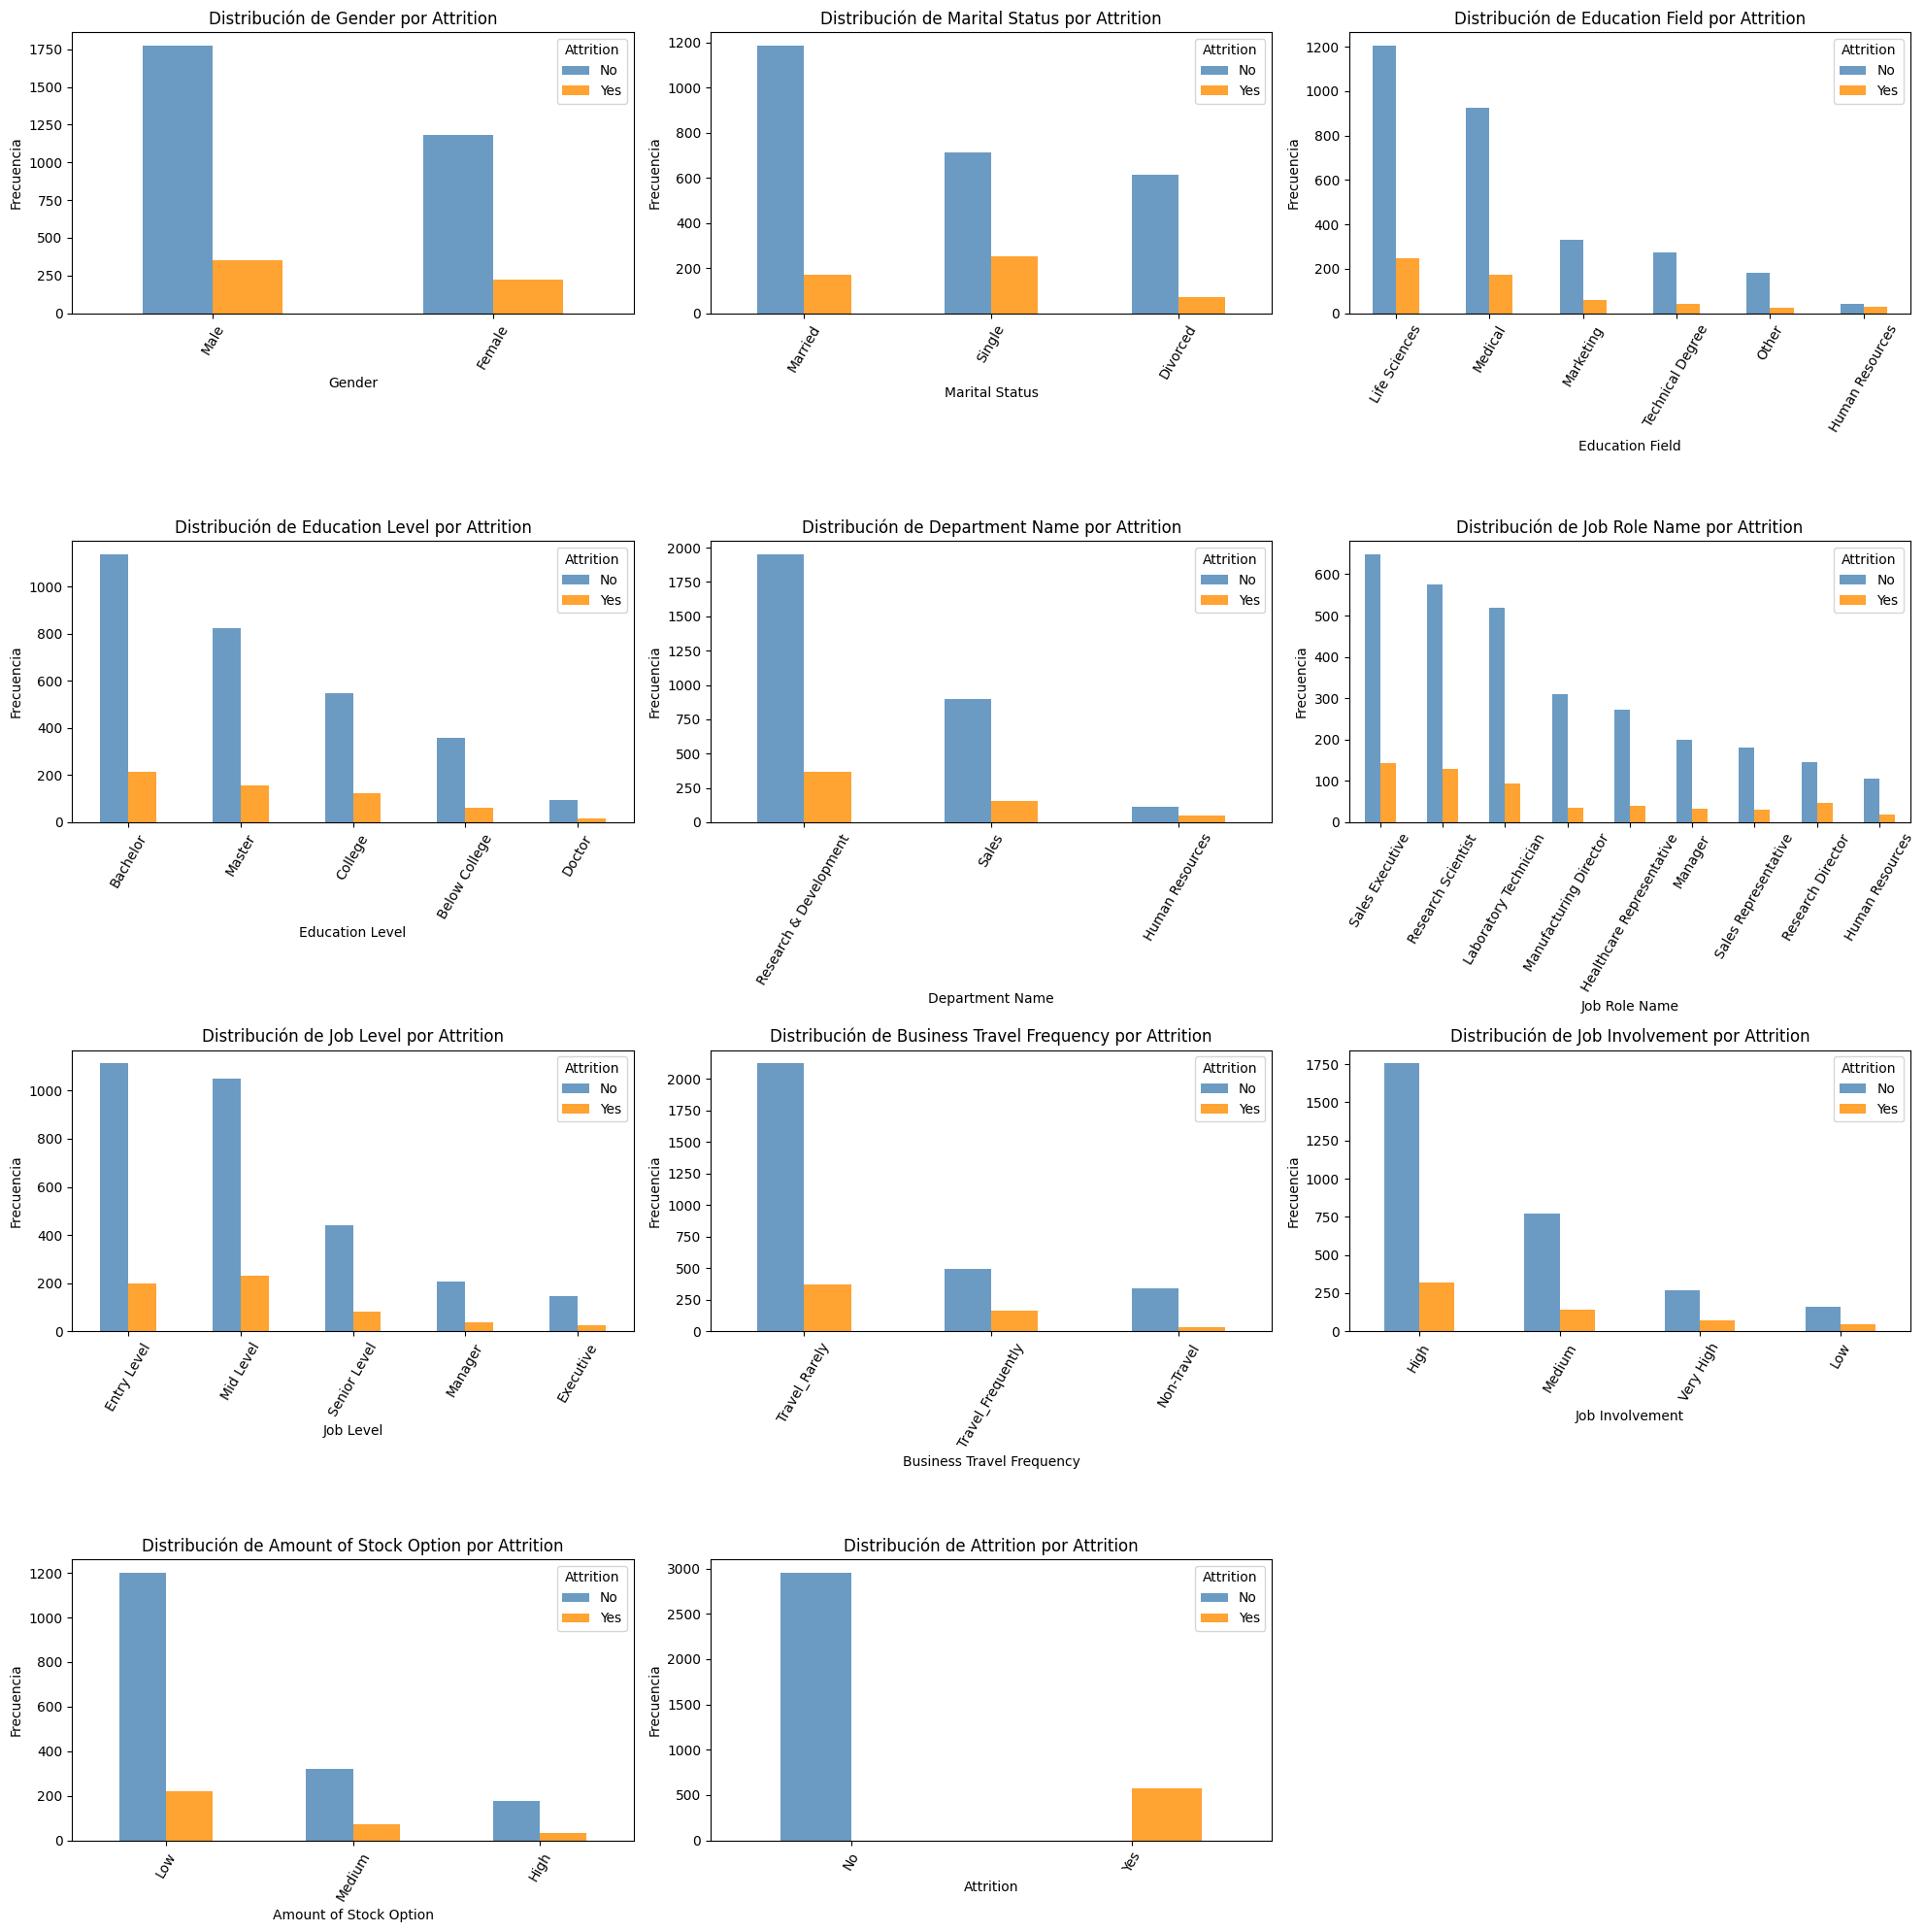

In [ ]:
# Detectar variables categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns

n = len(cat_cols)
rows = math.ceil(n / 3)  # 3 gráficos por fila

fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))
axes = axes.flatten()

# Colores por clase
colors = {'Yes': 'darkorange', 'No': 'steelblue'}

for i, col in enumerate(cat_cols):
    # Crear tabla de frecuencias cruzadas normalizadas
    counts = pd.crosstab(df[col], df['Attrition'])

    # Ordenar por frecuencia total (opcional, ayuda a visualizar)
    counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

    # Graficar barras lado a lado
    counts.plot(kind='bar', ax=axes[i],
            color=[colors['No'], colors['Yes']],  # orden explícito
            alpha=0.8)

    axes[i].set_title(f"Distribución de {col} por Attrition", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis='x', rotation=60)
    axes[i].legend(title='Attrition')

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Tal como con las variables numéricas, tampoco se observan grandes diferencias en cuanto a la distribución de las variables categóricas según la clase que tome `Attrition`.

## Observaciones sobre la estructura de los datos
1. No se detectan graves implicancias en relación a la presencia de missing values en el dataset. Además de ser solamente 8 las variables con presencia de missing values, 6 de las 7 muestran una proporción de los mismos inferior al 15% del total de observaciones, mientras que la variable restante que tiene missing values apenas pasa el 20% sobre el total de observaciones. Por lo tanto, se considera que hay suficiente información entre los valores no nulos de las variables para realizar inputaciones de los missing values lógicas y consistentes con la estructura de los datos.

2. Se observan más casos de trabajadores que abandonan su puesto que los que no lo hacen en personas menores a 20 años.

3. No se observan correlaciones significativas entre variables, con excepciones de algún par de variables en particular, como `Last Salary Increase (%)` y `Performance Rating`.

4. En relación a las distribuciones de las variables tanto cuantitativas como cualitativas, **NO** se detectó la presencia de outliers en ninguna de las variables observadas. En relación a las variables cualitativas, es razonable observar que variables que miden capacidad y formación, como `Job Level` o `Education Level` muestran una tendencia descentente a medida que el nivel técnico aumenta.

5. Las distribuciones de las variables tanto numéricas como categóricas no muestran diferencias notables según qué clase toma la variable `Attrition`.

6. La variable objetivo `Attrition` muestra un marcado desbalance entre clases, esto deberá ser tenido en cuenta más adelante en próximas etapas del proyecto.

7. No se detectaron otro tipo de anomalías en los datos en el sentido que todas muestran sus observaciones en un rango razonable.

8. La variable `ID` es totalmente irrelevante para el posterior entrenamiento de modelos de Machine Learning, por lo que **NO** será incluída en los mismos.

# División en entrenamiento y test

Se va a dividir el dataset en entreniamiento y test, en proporciones de 80% y 20%, respectivamente. Es importante recordar que el conjunto de test permanecerá intacto hasta el final del documento.

In [ ]:
# División en entrenamiento y test
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

### Comentarios sobre los parámetros seleccionados
1. `shuffle` establece que los datos serán aleatorizados antes de ser procesados, de modo que si existía algún tipo de orden preestablecido que distorsione el entrenamiento, el mismo será removido por la aleatorización de los datos

2. `stratify` se asegura que al momento de dividir el dataset en train y test, haya una proporción de clases similar de la variable objetivo en ambos datasets, de modo de evitar desbalances de la misma para un conjunto en relación al otro.

In [ ]:
X_train.shape

(2822, 25)

In [ ]:
X_test.shape

(706, 25)

# Breve análisis del train set

In [ ]:
# Comparo con el describe() anterior
X_train.describe()

,Age,Miles from Home to Work,Yearly Income,Absences per Year,Performance Rating,Job Satisfaction,Environment Satisfaction,Work Life Balance Satisfaction,Last Salary Increase (%),Number of Training Sessions Last Year,Number of Other Companies,Total Active Years,Years at Current Company,Years Since Last Promotion,Years with Current Manager
count,2822.000000,2250.000000,2822.000000,2822.000000,2822.000000,2668.000000,2683.000000,2654.000000,2822.000000,2822.000000,2811.000000,2818.000000,2822.000000,2822.000000,2822.000000
mean,36.700921,9.148889,64057.072998,12.788094,3.155918,2.735757,2.733135,2.770912,15.215096,2.787739,2.664532,11.103620,6.924876,2.147768,4.065911
std,9.108616,8.119087,46462.248269,5.486062,0.362842,1.096866,1.084589,0.699662,3.669356,1.270260,2.507260,7.702946,6.075388,3.170416,3.539604
min,18.000000,1.000000,10090.000000,1.000000,3.000000,1.000000,1.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,28910.000000,8.000000,3.000000,2.000000,2.000000,2.000000,12.000000,2.000000,1.000000,6.000000,3.000000,0.000000,2.000000
50%,35.000000,7.000000,48775.000000,13.000000,3.000000,3.000000,3.000000,3.000000,14.000000,3.000000,1.000000,10.000000,5.000000,1.000000,3.000000
75%,42.000000,14.000000,81200.000000,17.000000,3.000000,4.000000,4.000000,3.000000,18.000000,3.000000,4.000000,15.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,199990.000000,24.000000,4.000000,4.000000,4.000000,4.000000,25.000000,6.000000,9.000000,40.000000,40.000000,15.000000,17.000000


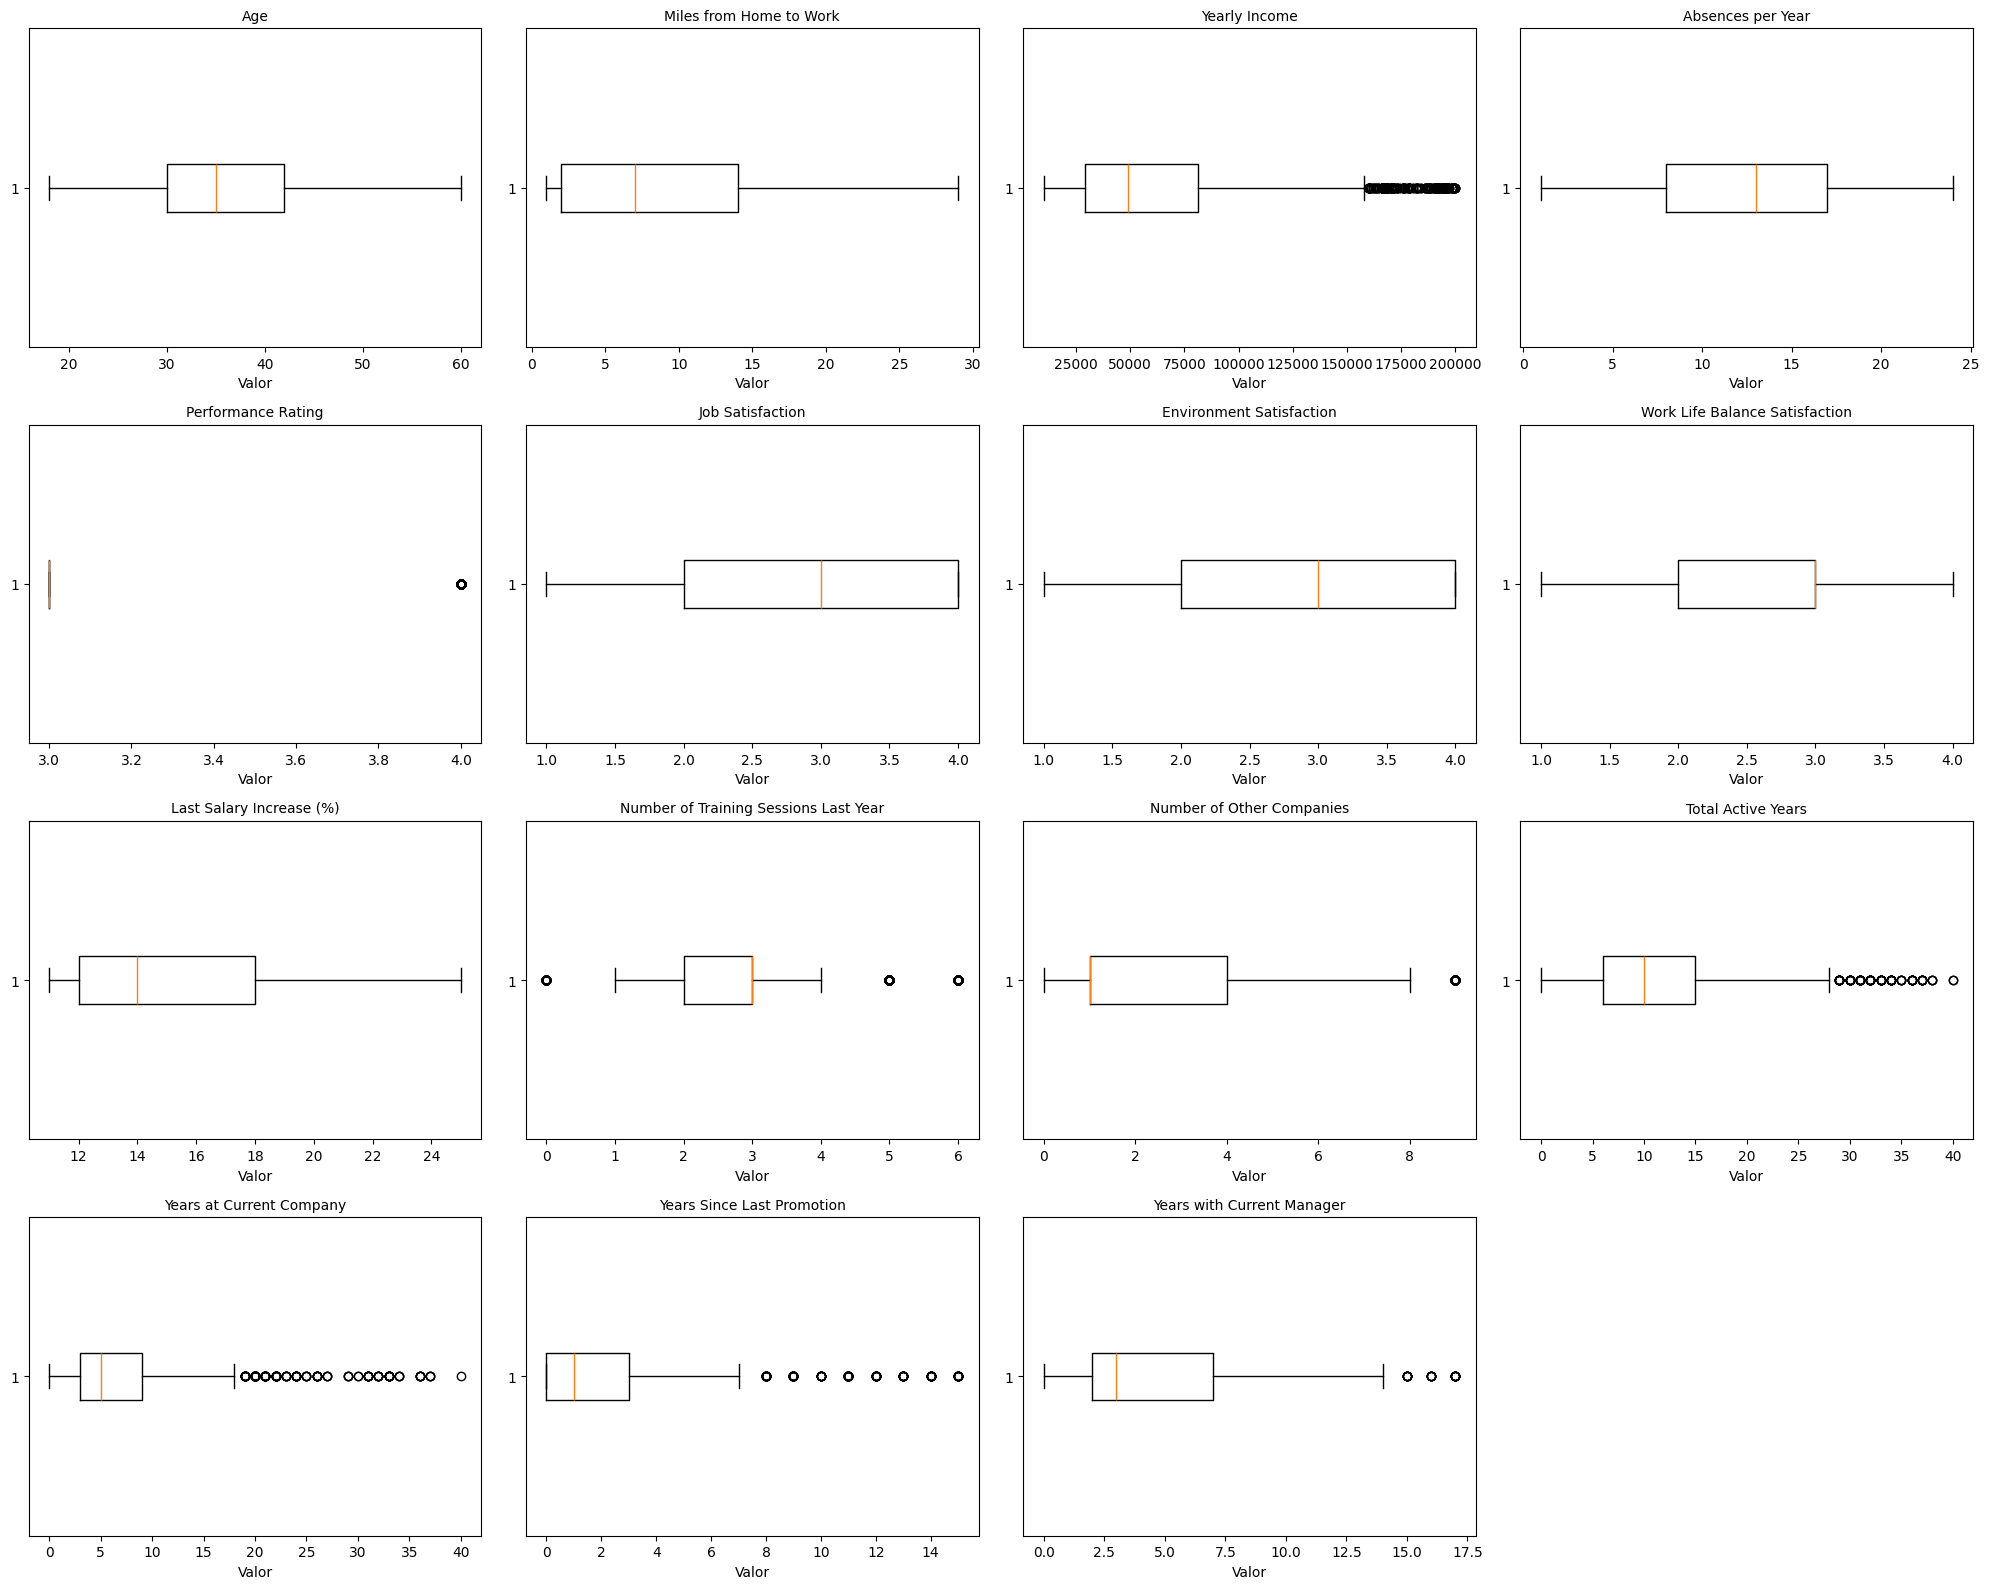

In [ ]:
# Se grafican una serie de boxplots para observar las distribuciones de las variables del train set
# Columnas numéricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Parámetros de grilla
n = len(num_cols)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
axes = axes.flatten()

# Generar boxplots
for i, col in enumerate(num_cols):
    axes[i].boxplot(X_train[col].dropna(), vert=False)
    axes[i].set_title(f"{col}", fontsize=10)
    axes[i].set_xlabel("Valor")

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Como se observó con los histogramas, esta variable toma valores 3 o 4, con un claro desbalance
X_train.value_counts('Performance Rating')

,count
Performance Rating,
3,2382
4,440


In [ ]:
# Breve observación de como lucen las variables categóricas en el dataset
# Columnas categóricas (dtype object)
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Columnas numéricas (dtype int o float)
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Columnas categóricas (object):", cat_cols)
print("\nColumnas numéricas (int o float):", num_cols)


Columnas categóricas (object): ['Gender', 'Marital Status', 'Education Field', 'Education Level', 'Department Name', 'Job Role Name', 'Job Level', 'Business Travel Frequency', 'Job Involvement', 'Amount of Stock Option']

Columnas numéricas (int o float): ['Age', 'Miles from Home to Work', 'Yearly Income', 'Absences per Year', 'Performance Rating', 'Job Satisfaction', 'Environment Satisfaction', 'Work Life Balance Satisfaction', 'Last Salary Increase (%)', 'Number of Training Sessions Last Year', 'Number of Other Companies', 'Total Active Years', 'Years at Current Company', 'Years Since Last Promotion', 'Years with Current Manager']


In [ ]:
X_train[cat_cols].head()

,Gender,Marital Status,Education Field,Education Level,Department Name,Job Role Name,Job Level,Business Travel Frequency,Job Involvement,Amount of Stock Option
185,Female,Married,Medical,Bachelor,Sales,Laboratory Technician,Entry Level,Travel_Rarely,Low,NaN
118,Male,NaN,Medical,Master,Research & Development,Sales Executive,Entry Level,Travel_Rarely,High,Low
2592,Male,Single,Life Sciences,Master,Sales,Healthcare Representative,Mid Level,Travel_Frequently,High,Low
284,Male,Single,Life Sciences,Below College,Research & Development,Manufacturing Director,Entry Level,Travel_Frequently,High,Low
421,Male,Single,Human Resources,College,Human Resources,Laboratory Technician,Entry Level,Travel_Rarely,High,Low


In [ ]:
# Dentro de las columnas categóricas, se dividen ordinales y nominales
nominales = ['Gender','Marital Status','Education Field','Department Name','Job Role Name']
ordinales = ['Education Level','Job Level','Business Travel Frequency','Job Involvement','Amount of Stock Option']

In [ ]:
# Breve observación de como lucen las variables cuantitativas en el dataset
X_train[num_cols].head()

,Age,Miles from Home to Work,Yearly Income,Absences per Year,Performance Rating,Job Satisfaction,Environment Satisfaction,Work Life Balance Satisfaction,Last Salary Increase (%),Number of Training Sessions Last Year,Number of Other Companies,Total Active Years,Years at Current Company,Years Since Last Promotion,Years with Current Manager
185,24,7.0,12320,7,3,2.0,4.0,3.0,12,4,1.0,1.0,1,0,0
118,38,7.0,66530,15,4,NaN,4.0,3.0,20,2,7.0,10.0,1,0,0
2592,38,18.0,41620,19,3,3.0,NaN,3.0,15,1,0.0,10.0,9,1,8
284,25,1.0,109320,5,3,4.0,NaN,3.0,11,3,1.0,1.0,1,1,0
421,21,10.0,53730,6,3,2.0,3.0,3.0,12,2,1.0,1.0,1,0,0


# Preprocesado de los datos

En esta sección se va a desarrollar un Pipeline de preprocesado de los datos que incluirá los siguientes pasos:

1. **Imputación de valores nulos:** para las columnas numéricas se imputará el valor de la mediana, mientras que para las columnas categóricas se imputará el valor con mayor frecuencia, es decir, la moda.
2. **Imputaciones particulares de valores nulos**: para las columnas mencionadas anteriormente, se ejecutarán una serie de imputaciones bajo criterios específicos para la columna correspondiente.
3. **Codificación de variables categóricas:** en el caso de las columnas categóricas se empleará one-hot encoding, mientras que para las columnas ordinales se empleará codificación ordinal.
4. **Normalización:** se escalarán los datos, de modo que sigan una distribución normal con media en 0 y desviación estándar 1.

**Nota técnica extraída del Notebook _"End-to-End ML Pipeline v2"_ publicado en Aula Global**

Hay algunas cuestiones que quizás son poco intuitivas, pero hay que incluirlas:
+ `verbose_feature_names_out=False`: esto impide que el `ColumnTransformer` cambie el nombre a las columnas, si no se hiciera, el segundo `ColumnTransformer` tendría que tener nombres de columnas distintos.
+ `set_output(transform='pandas')`: el ColumnTransformer devuelve por defecto un array de Numpy, al incluir esta línea de código, la salida se mantiene como DataFrame (para poder pasar por otros `ColumnTransformer`` distintos).


In [ ]:
print(cat_cols)
print(num_cols)

['Gender', 'Marital Status', 'Education Field', 'Education Level', 'Department Name', 'Job Role Name', 'Job Level', 'Business Travel Frequency', 'Job Involvement', 'Amount of Stock Option']
['Age', 'Miles from Home to Work', 'Yearly Income', 'Absences per Year', 'Performance Rating', 'Job Satisfaction', 'Environment Satisfaction', 'Work Life Balance Satisfaction', 'Last Salary Increase (%)', 'Number of Training Sessions Last Year', 'Number of Other Companies', 'Total Active Years', 'Years at Current Company', 'Years Since Last Promotion', 'Years with Current Manager']


In [ ]:
print(ordinales)

['Education Level', 'Job Level', 'Business Travel Frequency', 'Job Involvement', 'Amount of Stock Option']


In [ ]:
# Observamos los valores que toma cada variable ordinal para definir su orden en el paso de ordinal encoding en el pipeline
for i in ordinales:
    print(i)
    print(X_train[i].value_counts().keys())
    print("\n")

Education Level
Index(['Bachelor', 'Master', 'College', 'Below College', 'Doctor'], dtype='object', name='Education Level')


Job Level
Index(['Entry Level', 'Mid Level', 'Senior Level', 'Manager', 'Executive'], dtype='object', name='Job Level')


Business Travel Frequency
Index(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype='object', name='Business Travel Frequency')


Job Involvement
Index(['High', 'Medium', 'Very High', 'Low'], dtype='object', name='Job Involvement')


Amount of Stock Option
Index(['Low', 'Medium', 'High'], dtype='object', name='Amount of Stock Option')




## Desarrollo de los transformadores que integrarán el pipeline

In [ ]:
# 1. Imputación de valores nulos.
imputer = ColumnTransformer(
    transformers=[
        ('imputer_num', SimpleImputer(strategy='median'), ['Age', 'Miles from Home to Work', 'Yearly Income',
                                                           'Absences per Year', 'Performance Rating', 'Job Satisfaction',
                                                           'Environment Satisfaction', 'Work Life Balance Satisfaction',
                                                           'Last Salary Increase (%)', 'Number of Training Sessions Last Year',
                                                           'Number of Other Companies', 'Total Active Years',
                                                           'Years at Current Company', 'Years Since Last Promotion',
                                                           'Years with Current Manager']),
        ('imputer_cat', SimpleImputer(strategy='most_frequent'), ['Gender', 'Marital Status', 'Education Field',
                                                                  'Education Level', 'Department Name', 'Job Role Name',
                                                                  'Job Level', 'Business Travel Frequency', 'Job Involvement']),
        ('imputer_stock_option', SimpleImputer(strategy='constant', fill_value='None'), ['Amount of Stock Option']),
    ], remainder='passthrough', verbose_feature_names_out=False,
)
imputer.set_output(transform='pandas') # esta función es para que el output sea un pandas dataframe y no en un numpy array
# se imputa la MEDIANA en imputer_num porque es menos susceptible a outliers que la media

# 2. Codificación numérica. Depende si la variable categorica es ordinal o no aplico distintas funciones
encoder = ColumnTransformer(
    transformers=[
        ('encoder_gender', OneHotEncoder(sparse_output=False), ['Gender']),
        ('encoder_marital_status', OneHotEncoder(sparse_output=False), ['Marital Status']),
        ('encoder_education_field', OneHotEncoder(sparse_output=False), ['Education Field']),
        ('encoder_department_name', OneHotEncoder(sparse_output=False), ['Department Name']),
        ('encoder_job_role_name', OneHotEncoder(sparse_output=False), ['Job Role Name']),
        ('encoder_education_level', OrdinalEncoder(categories=[['Below College','College','Bachelor','Master','Doctor']]), ['Education Level']),
        ('encoder_job_level', OrdinalEncoder(categories=[['Entry Level', 'Mid Level', 'Senior Level', 'Manager', 'Executive']]), ['Job Level']),
        ('encoder_business_travel_frequency', OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely', 'Travel_Frequently']]), ['Business Travel Frequency']),
        ('encoder_job_involvement', OrdinalEncoder(categories=[['Low','Medium','High','Very High']]), ['Job Involvement']),
        ('encoder_amount_stock_option', OrdinalEncoder(categories=[['None','Low', 'Medium', 'High']]), ['Amount of Stock Option'])
    ], remainder='passthrough', verbose_feature_names_out=False,
)
encoder.set_output(transform='pandas')

# 3. Escalado.
# Se va a emplear el escalado descripto más arriba
scaler = StandardScaler()
# Se van a escalar TODAS las columnas

# Justificación de los modelos a implementar
En esta sección, se desarrollará una breve justificación, junto con las ventajas y desventajas que ofrece cada modelo que se testeará en las siguiente secciones. El propósito de esto es, en base a las limitaciones que tiene cada algoritmo intentar neutralizarlas lo máximo posible a través de las virtudes de los demás modelos.
<br><br>

## 1. Regresión logística

<p align="center">
  <img src="https://media.licdn.com/dms/image/v2/D4D12AQGIXdSG7IJCNw/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1694183259537?e=2147483647&v=beta&t=lJ_qEzot0iGYhNpez9XGRNHjS-CDKHn3Wj-6iCQxRO0" width="50%">
</p>

La elección del modelo de resgresión logística se justifica en que es un modelo simple e interpretable, que a través de aplicar la función sigmoide a la combinación lineal de parámetros, es capaz de devolver una probabilidad de que un empleado abandone su trabajo. Por otro lado, puede no ser lo suficientemente potente y robusto como algunos de los modelos más complejos planteados a continuación. El tipo de penalización (`penalty`) va a definir la forma en que se regularizan los coeficientes, afectando la capacidad del modelo para seleccionar variables y manejar colinealidades. También se ajustará el parámetro `solver`, de modo de garantizar una convergencia eficiente según el tamaño del dataset o el tipo de regularización.
<br><br>


## 2. Árboles de decisión

<p align="center">
  <img src="https://www.shutterstock.com/image-vector/linear-icon-decision-tree-600nw-2503126507.jpg" width="40%%">
</p>

Los árboles de decisión dividen sucesivamente el espacio de características en regiones homogéneas según una métrica de pureza establecida. Son modelos fáciles de interpretar y pueden capturar relaciones no lineales entre variables. De todas formas, son susceptibles a caer en overfitting si no son debidamente configurados en sus hiperparámetros. Si bien, en la práctica, algoritmos de ensemble como Random Forests tienden a mostrar mejores resultados que los árboles de decisión por sí solos, se van a incluir de todas maneras en el estudio. En términos de parámetros clave, se explorarán distintas combinaciones de `criterion`, que define la métrica por la cual se mide la pureza de cada nodo (en este caso se empleará el Índice de Gini y la entropía), y de `max_depth` que indica la profundidad del árbol. Éste último parámetro es fundamental configurarlo de forma adecuada ya que una profundidad baja tiende a simplificar el modelo pero una profundidad muy alta puede hacer que el mismo sobreajuste.
<br><br>


## 3. K-Nearest Neighbors (KNN)

<p align="center">
  <img src="https://www.researchgate.net/publication/337085301/figure/fig1/AS:822616529068039@1573138472769/Schematic-diagram-of-KNN-classification-is-a-schematic-diagram-of-KNN-classification-X.png" width="50%">
</p>

El clasificador KNN, a diferencia de los dos modelos previos planteados hasta el momento, es un modelo no paramétrico, esto implica que su entrenamiento no va a basarse en ajustar parámetros sino a predecir la clase de una observación según las clases de sus K vecinos más cercanos en el espacio de características. Es un método intuitivo y flexible, capaz de modelar fronteras de decisión complejas. Su principal desventaja es el alto costo computacional en predicción, ya que requiere calcular distancias a todos los puntos del conjunto de entrenamiento. En este caso particular, la dimensionalidad es alta dado que hay una cantidad significativa de predictores, lo que puede degradar el rendimiento del modelo, dependiendo de las relaciones y correlaciones entre las variables. El parámetro más determinante en KNN es el número de vecinos `n_neighbors`, ya que precisamente indica cuántos vecinos se tomarán en cuenta a la hora de clasificar una observación nueva. Este parámetro juega con el trade-off entre sesgo y varianza, a mayor K se reduce la varianza pero aumenta el sesgo, y viceversa para un valor bajo de K. Además también resulta importante ajustar la métrica de distancia (`metric`), que normalmente es la Euclidiana o Manhattan, así como el peso de los vecinos (`weights`), que define si todos los vecinos contribuyen por igual o si los más cercanos tienen mayor influencia
<br><br>


## 4. MLPs (Percepción multicapa)

<p align="center">
  <img src="https://i.sstatic.net/6qBc8.jpg
" width="60%">
</p>

Los Multilayer Perceptrons son redes neuronales que combinan capas de neuronas con funciones de activación no lineales (en este caso se implementarán la función sigmoide, la función ReLU y la tangente hiperbólica) para modelar relaciones complejas entre las variables, y así salir de la linealidad. Su gran ventaja es la capacidad de aproximar dichas funciones no lineales y su poder predictivo. Sin embargo, requiere ajustar muchos hiperparámetros, como el número de capas, neuronas o el learning rate, puede necesitar grandes volúmenes de datos y su entrenamiento es costoso computacionalmente, además de ser significativamente menos interpretable que otros modelos. En redes neuronales de tipo MLP, los hiperparámetros clave son la estructura de la red (`hidden_layer_sizes`), el `learning_rate` y las distintas funciones de activación de cada neurona, bajo el parámetro `activation`.
<br><br>


## 5. Random Forests

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*jE1Cb1Dc_p9WEOPMkC95WQ.png" width="60%">
</p>

Como fue mencionado en la justificación del uso de árboles de decisión, el Random Forest es un método de ensemble que combina múltiples árboles de decisión entrenados sobre subconjuntos aleatorios de datos y variables. Reduce el sobreajuste típico de los árboles por sí solos y mejora la estabilidad y precisión, además de ser robusto frente a ruido y outliers. Sin embargo, su principal desventaja es que es menos interpretable que otros modelos y puede ser computacionalmente costoso, especialmente si se entrenan muchos árboles o árboles con demasiadas variables. En Random Forest, los parámetros críticos son el número de árboles (`n_estimators`), la profundidad máxima (`max_depth`) y el criterio de evaluación de pureza de los nodos, que al igual que para árboles de decisión el parámetro se denomina `criterion`. Aumentar la cantidad de árboles generalmente mejora la estabilidad del modelo, aunque a costa de mayor tiempo de cómputo. Por otro lado, el control de la profundidad de cada árbol evita que los árboles individuales sobreajusten.
<br><br>


## 6. Gradient Boosting
<p align="center">
  <img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/fc/4f/ensemble-learning-boosting.component.xl.ts=1744838363574.png/content/adobe-cms/us/en/think/topics/gradient-boosting/jcr:content/root/table_of_contents/body-article-8/image_180162990" width="60%">
</p>

Gradient Boosting construye un conjunto de árboles secuencialmente, donde cada nuevo árbol corrige los errores del anterior mediante el gradiente del error, ofreciendo gran precisión y flexibilidad. De todas formas, puede ser más lento de entrenar que otros modelos, así como computacionalmente más costoso. En términos de parámetros, el GradientBoosting comparte con Random Forest los parámetros que controlan la cantidad de árboles (`n_estimators`) y la profundidad de cada árbol individual (`max_depth`), pero al ser un modelo que aprende secuencialmente, también debe ser considerado el `learning_rate`, ya que su valor puede requerir distintas cantidades de iteraciones para alcanzar un ajuste adecuado.
<br><br>


## 7. Support Vector Classifier (SVC)
<p align="center">
  <img src="https://la.mathworks.com/discovery/support-vector-machine/_jcr_content/mainParsys/band_1231704498_copy/mainParsys/lockedsubnav/mainParsys/columns/4d6875cb-8556-43eb-9393-53bcec9e3682/columns/29ee2f91-358a-4aca-8f04-e0f536feb8f2/image_2128876021_cop.adapt.full.medium.jpg/1758267557638.jpg" width="40%">
</p>


El algoritmo de Support Vector Classifier (SVC) busca el hiperplano que mejor separa las clases maximizando el margen entre ellas. Es eficaz en espacios de alta dimensión (como en este problema particular) y con fronteras no lineales, a través del uso de kernels. Entre sus ventajas están su robustez y capacidad para manejar fornteras de decisión complejas. Como desventajas, es poco escalable en datasets grandes, requiere una cuidadosa elección del kernel y parámetros de regularización, y su interpretación no es tan directa. En el SVC, los parámetros esenciales son el coeficiente de penalización `C` y el `kernel`. El valor de `C` controla la tolerancia a los errores de clasificación, donde valores grandes fuerzan un ajuste estricto, mientras que valores pequeños permiten un margen más amplio pero con mayor sesgo, mientras que el `kernel` define la forma del espacio transformado, afectando directamente la complejidad del modelo.
<br><br>


## 8. Linear Discriminant Analysis (LDA)
<p align="center">
  <img src="https://www.appliedaicourse.com/blog/wp-content/uploads/2024/10/Linear-Discriminant-Analysis-in-Machine-Learning-1024x673.jpg" width="60%">
</p>

LDA tiene como objetivo principal  encontrar una combinación lineal de variables predictoras que permita maximizar la separación entre las clases de la variable objetivo. Entre sus principales ventajas, destacan su simplicidad computacional, la interpretabilidad de los resultados y su buen rendimiento en problemas donde las clases son linealmente separables. Además, permite reducir la dimensionalidad de los datos de manera supervisada, conservando la información relevante para la clasificación. Sin embargo, LDA asume que las variables siguen una distribución normal multivariante y que las matrices de covarianza de las clases son iguales, condiciones que no siempre se cumplen en la práctica. Esta puede ser una de las razones por las cuales los modelos LDA muestran resultados débiles en el entrenamiento realizado en las celdas siguientes. En LDA, los hiperparámetros principales son el `solver` y la opción de `shrinkage`. El `solver` define el método de optimización empleado para calcular las proyecciones y su elección influye en la estabilidad numérica del modelo según el tamaño del dataset. El parámetro de `shrinkage`, cuando está disponible, controla el grado de regularización de la matriz de covarianzas, resultando útil cuando existen muchas variables o cuando la multicolinealidad es elevada.

# Creación del pipeline y búsqueda de modelos (e hiperparámetros)
Una pipeline nos permitirá llevar a cabo todo el proceso:
1. Imputación de valores nulos.
2. Codificación de variables categóricas / ordinales.
3. Escalado.
4. Modelo de ML para clasificación.

Una vez creado el pipeline, vamos a realizar una búsqueda de hiperparámetros mediante la función `GridSearchCV`, que pruebe diferentes configuraciones para los siguientes modelos descriptos a continuación.
1. Regresión logística
2. Árboles de decisión
3. KNN
4. Perceptrón multicapa
5. Random Forests
6. Gradient Boosting
7. Support Vector Classifier
8. Linear Discriminant Analysis

El modelo de búsqueda probará todas las combinaciones de la rejilla, empleando validación cruzada de 3 hojas.

**Incorporación de `SMOTE()`:**
Tal como fue remarcado en la sección de análisis sobre la estructura de los datos, se puede observar un claro desbalance entre clases en la variable objetivo `Attrition`, esto puede distorsionar significativamente la capacidad de clasificación de un modelo, por ello, sería apropiado tomar alguna acción al respecto.

Para abordar este aspecto, se va a incorporar al pipeline la función `SMOTE` de la librería `imbalanced-learn`. Dicha función genera observaciones sinteticas de la clase minoritaria que son similares a las observaciones reales en cuanto a su distribución y estructura estadística. Esto genera un dataset con ambas clases balanceadas y luego entrena los distintos modelos con ese dataset balanceado, lo que pretende lograr mejores resultados en cuanto a la generalización de las clasificaciones.


## Entrenamiento de la grilla con todos los modelos y sus hiperparámetros para encontrar a los óptimos

In [ ]:
# 1. Creación de la grilla de hiperparámetros
ml_pipe = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler),
    ('smote', SMOTE(random_state=42)),
    ('classifier', None)]
)
grid = [
    {
        'classifier': [LogisticRegression(random_state=42, class_weight='balanced')],
        'classifier__solver': ['lbfgs', 'newton-cg'],
        'classifier__penalty': ['l2', 'none']
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=42, class_weight='balanced')],
        'classifier__criterion': ['entropy', 'gini'],
        'classifier__max_depth': [None, 2, 5, 10, 15, 20]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 11, 15],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2, 3]
    },
    {
        'classifier': [MLPClassifier(random_state=42)],
        'classifier__hidden_layer_sizes': [(64,), (128,), (32, 64), (64, 128), (64, 32, 16)],
        'classifier__activation': ['relu', 'logistic', 'tanh'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate': ['constant', 'adaptive']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__n_estimators': [20, 50, 100, 200],
        'classifier__criterion': ['entropy', 'gini'],
        'classifier__max_depth': [None, 2, 5, 10]
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200, 300, 400, 500, 600],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    {
        'classifier': [SVC(random_state=42, class_weight='balanced')],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [LinearDiscriminantAnalysis()],
        'classifier__solver': ['svd', 'lsqr', 'eigen'],
        'classifier__shrinkage': [None, 'auto']
    }

]

# 2. Búsqueda de hiperparámetros.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # esto hace una CV estratificada
search = GridSearchCV(ml_pipe, grid, scoring='balanced_accuracy', cv=cv) # el criterio es la accuracy
search.fit(X_train, y_train)

,estimator,"Pipeline(step...fier', None)])"
,param_grid,"[{'classifier': [LogisticRegre...ndom_state=42)], 'classifier__penalty': ['l2', 'none'], 'classifier__solver': ['lbfgs', 'newton-cg']}, {'classifier': [DecisionTreeC...ndom_state=42)], 'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [None, 2, ...]}, ...]"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('imputer_num', ...), ('imputer_cat', ...), ...]"


# Comparativa de modelos

De forma sencilla, podemos crear un DataFrame con los resultados del proceso de búsqueda. Podemos acceder al objeto `RandomSearchCV` empleando el parámetro `named_steps` de la pipeline. El siguiente código fue extraído y adaptado para este documento del notebook publicado en Aula Global, llamado *End-to-End ML Pipeline v2*.

A continuación, podemos hacer un poco de limpieza del dataframe para aumentar la claridad de las columnas.

In [ ]:
# Obtenemos el dataframe con los resultados.
results = pd.DataFrame(search.cv_results_)

# Vamos a simplificar los nombres de las columnas.
# 1. Quitamos el texto 'classifier__'
# 2. Renombramos la columna 'param_classifier' por simplemente 'classifier'.
results.rename(columns=lambda s : s.replace('classifier__', ''), inplace=True)
results.rename(columns=lambda s : s.replace('param_classifier', 'classifier'), inplace=True)

# Vamos a quitar los parámetros del clasificador.
results['classifier'] = results.classifier.apply(lambda c : c.__class__.__name__)

# Vamos a quitar la columna 'params' por ser redundante.
results.drop(columns=['params'], inplace=True)

# Ordenamos las columnas alfabéticamente.
results = results[sorted(results)]

# Ordenamos los modelos por ranking, de mejor a peor.
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(inplace=True)

# Mostramos los resultados.
display(results.head(15))

,index,classifier,mean_fit_time,mean_score_time,mean_test_score,param_C,param_activation,param_alpha,param_criterion,param_gamma,...,param_shrinkage,param_solver,param_weights,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
0,17,KNeighborsClassifier,0.062650,0.187156,0.875647,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,distance,1,0.888574,0.855102,0.883265,0.000938,0.005597,0.014688
1,23,KNeighborsClassifier,0.062367,0.185527,0.873300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,distance,2,0.890129,0.853484,0.876286,0.000651,0.007234,0.015108
2,29,KNeighborsClassifier,0.063382,0.188640,0.866147,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,distance,3,0.881880,0.844601,0.871961,0.001159,0.005048,0.015764
3,214,GradientBoostingClassifier,15.590325,0.059649,0.863996,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4,0.876008,0.847326,0.868655,0.155792,0.010826,0.012164
4,215,GradientBoostingClassifier,18.421295,0.057865,0.863316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5,0.875373,0.850594,0.863979,0.469960,0.010473,0.010127
5,213,GradientBoostingClassifier,12.244511,0.047645,0.861825,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6,0.872105,0.840790,0.872579,0.151862,0.007885,0.014875
6,196,GradientBoostingClassifier,16.691908,0.053074,0.861419,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,0.872105,0.849325,0.862827,1.711231,0.009225,0.009353
7,212,GradientBoostingClassifier,9.371080,0.044934,0.861010,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8,0.869567,0.843423,0.870041,0.169947,0.007904,0.012437
8,197,GradientBoostingClassifier,18.653333,0.054977,0.860746,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,0.872740,0.849959,0.859538,0.280784,0.008473,0.009339
9,19,KNeighborsClassifier,0.062927,0.055918,0.857935,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,distance,10,0.871728,0.819664,0.882414,0.002894,0.005103,0.027411


Se puede observar que de los 15 modelos que mostraron mejores rendimientos en el validation set, **[COMPLETAR !!!!!]** . En la siguiente sección se analizará más al detalle si efectivamente éstos son los mejores modelos, al implementarlos en el test set.

# Métricas clave para evaluar rendimiento de cada modelo
Para evaluar el rendimiento de los modelos se medirán los valores de las siguientes métricas de la librería `sklearn`, que también pueden ser extraídas de la matriz de confusión de la variable objetivo.



<p align="center">
  <img src="https://images.prismic.io/encord/edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.png?auto=compress,format" width="60%">
</p>


1. `balanced_accuracy_score` = (`Sensitivity`+`Specificity`)/2

Promedia la capacidad del modelo para acertar tanto en la clase positiva como en la negativa, compensando posibles desequilibrios de clase

2. `precision_score`

De todas las observaciones que el modelo predijo como positivas, cuántas eran realmente positivas. Esta métrica es relevante dado que hay un claro desbalance entre clases de la variable objetivo.


3. `recall_score`

De todas las observaciones que realmente son positivas, cuántas detectó el modelo correctamente. Así como `precisio_score`, es relevante para este problema por la misma justificación que en el caso anterior.


4. `f1_score` = 2 x (`precision_score`x`recall_score`) / (`precision_score`+`recall_score`)

Combina `precisio_score` y `recall_score` en una sola métrica armónica. Sirve para evaluar el modelo cuando se pretende un equilibrio entre ambos para evitar falsos positivos y falsos negativos.
<br><br>

**Criterios:**

A la hora de evaluar los distintos modelos que se van a entrenar, para seleccionar el modelo definitivo no solo se tomará en cuenta su rendimiento en términos de `balanced_accuracy_score`, sino que ademas se lo evaluará en términos del resto de las métricas planteadas, de modo de encontrar aquel modelo que mejor logre balancear las mismas, logrando una capacidad predictiva más integral.

# Rendimiento del mejor modelo
Se evalúa al mejor modelo en el validation set pero ahora en el test set.

In [ ]:
# Rendimiento en validación
acc_val = search.best_score_
print(f'Tasa de aciertos sobre validación: {(100 * acc_val):.2f} %')

# Estimación del rendimiento en test
y_pred = search.predict(X_test)
y_pred_proba = None
try:
    y_pred_proba = search.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva
except AttributeError:
    print("El clasificador no soporta predict_proba, se calculará AUC con decision_function si existe.")
    try:
        y_pred_proba = search.decision_function(X_test)
    except AttributeError:
        print("No se puede calcular AUC para este clasificador.")

acc_test = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Yes',average='binary')
recall = recall_score(y_test, y_pred, pos_label='Yes',average='binary')
f1 = f1_score(y_test, y_pred, pos_label='Yes',average='binary')

print(f'Tasa de aciertos sobre test: {(100 * acc_test):.2f} %')
print(f'Precision: {(100*precision):.2f} %')
print(f'Recall: {(100*recall):.2f} %')
print(f'F1 Score: {(100*f1):.2f} %')

if y_pred_proba is not None:
    auc = roc_auc_score((y_test == 'Yes').astype(int), y_pred_proba)
    print(f'AUC: {(100*auc):.2f} %')


Tasa de aciertos sobre validación: 87.56 %
Tasa de aciertos sobre test: 94.09 %
Precision: 85.25 %
Recall: 91.23 %
F1 Score: 88.14 %
AUC: 94.46 %


Este modelo muestra resultados poisitivos en el test set, sin embargo, también se evaluarán en el test set aquellos modelos que completen el top 10 según el `balanced_accuracy_score` en el validations set, para determinar si el modelo  efectivamente es el que mejores resultados muestra en el test set. Puede darse el caso de que otro modelo muestre una `balanced_accuracy_score` inferior pero que compense con mejores resultados en las otras métricas, ya que, por ejemplo tanto la `precision_score` como el `f1_score` tienen margen de mejora.

In [ ]:
# Ordenar resultados y tomar top 5
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
top5 = results.head(10)

for i, row in top5.iterrows():
    params = row['params']
    # Clonar pipeline y setear parámetros
    model = clone(ml_pipe)
    model.set_params(**params)
    model.fit(X_train, y_train)

    # Predicciones en test
    y_pred = model.predict(X_test)

    # Métricas
    acc_test = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Yes')
    recall = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')

    print("="*60)
    print(f"Modelo rank {row['rank_test_score']} con params={params}")
    print(f"Balanced Accuracy (test): {(100*acc_test):.2f}%")
    print(f"Precision (test): {(100*precision):.2f}%")
    print(f"Recall (test): {(100*recall):.2f}%")
    print(f"F1 Score (test): {(100*f1):.2f}%")

Modelo rank 1 con params={'classifier': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'), 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'distance'}
Balanced Accuracy (test): 94.09%
Precision (test): 85.25%
Recall (test): 91.23%
F1 Score (test): 88.14%
Modelo rank 2 con params={'classifier': KNeighborsClassifier(p=1, weights='distance'), 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}
Balanced Accuracy (test): 93.94%
Precision (test): 80.77%
Recall (test): 92.11%
F1 Score (test): 86.07%
Modelo rank 3 con params={'classifier': KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'), 'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'distance'}
Balanced Accuracy (test): 93.54%
Precision (test): 75.18%
Recall (test): 92.98%
F1 Score (test): 83.14%
Modelo rank 4 con params={'classifier': GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=500,
                         

Luego de comparar en el test set las métricas relevantes con los mejores 10 modelos en el validation set, se puede observar una marcada presencia de modelos basados en GradientBoosting. El modelo seleccionado será el que se ubica en la posición 4 del ranking mostrado en la celda anterior.

Por lo señalado anteriormente, tras analizar otros modelos además del que el pipeline destaca como el óptimo, se determinó que el modelo seleccionado como óptimo para la competencia posterior consiste en un GradientBoosting con `learning_rate` igual a 20%, lo que refleja una tasa de aprendizaje moderada, con 500 árboles de decisión (`n_estimators` = 500), donde cada árbol particular tiene una baja profundidad de 5 nodos (`max_depth` = 5). Por último, el parámetro `subsample` = 1.0 (que viene por default) indica que en cada iteración se emplea la totalidad de las observaciones disponibles para entrenar los árboles, lo que reduce la varianza y mejora la estabilidad del modelo, aunque con menor efecto regularizador que valores menores a 1.

En este caso, la selección de hiperparámetros fue fundamental para alcanzar los resultados que se obtuvieron. Un `learning_rate` del 20% permite que el modelo aprenda a un ritmo razonablemente rápido sin caer en overfitting, mientras que los 500 árboles le dan la capacidad de capturar relaciones complejas entre las variables. La profundidad de 5 nodos resulta un punto de equilibrio adecuado para poder representar interacciones no lineales, pero sin perder capacidad de generalización.

Este modelo se seleccionó porque, si bien no es el que tiene la `balanced_accuracy_score` más alta, sí es el que mejor balancea todas las métricas relevantes para tratar un problema de las características del de este documento, como los desbalanceos entre la variable objetivo o las relaciones complejas que existen entre las variables predictoras. Además, GradientBoosting tiene la particularidad de que, si bien no hace subset selection explícitamente, sí lo hace indirectamente a través de las variables por las cuales el modelo hace los splits en los nodos de todos sus árboles individuales. Para cada nodo, el árbol elige automáticamente la variable más relevante para ese split, lo que hace que variables que aportan poca información casi nunca se usan en los splits, haciendo su contribución al modelo prácticamente nula.

Existen diversas razones para justificar el rendimiento superior tanto de este modelo como de los otros GradientBoosting. En primer lugar, GradientBoosting combina múltiples modelos débiles (en este caso árboles de decisión) de forma secuencial, donde cada nuevo árbol intenta corregir los errores de los modelos anteriores. Este enfoque iterativo permite capturar relaciones complejas entre las variables predictoras y la variable objetivo, incluso cuando las fronteras de decisión no son lineales. Además, su capacidad para ajustar pesos de manera dinámica le otorga una ventaja frente a modelos lineales o menos flexibles, ya que puede aprender patrones residuales y mejorar progresivamente el rendimiento sin incurrir en un sobreajuste excesivo si se regula adecuadamente.

Por otro lado, el hecho de haber estandarizado las variables numéricas antes de entrenar el modelo contribuye a mejorar la estabilidad y eficiencia del aprendizaje. Si bien Gradient Boosting no es tan sensible a la escala como otros algoritmos, este paso asegura que todas las variables participen de manera equilibrada en la construcción de los árboles. En conjunto, estos factores explican por qué esta configuración logra el mejor rendimiento en el conjunto de prueba: combina una buena capacidad de ajuste con una generalización sólida, lo que la convierte en la opción más robusta y consistente dentro de las evaluadas.

# Preparación del mejor modelo para competición

Finalmente, vamos a tomar el mejor modelo y montar la pipeline final. Esta pipeline la entrenaremos con el conjunto de datos final que utilizaríamos posteriormente para la competición. Como ya sabemos, por la demostración de arriba, que el mejor modelo es un GradientBoosting con los parámetros especificados, nos encargamos de seleccionarlo particularmente para su posterior serialización.

In [ ]:
# MEJOR MODELO - Gradient boost
gradient_boost_results = results[results['param_classifier'].apply(lambda x: isinstance(x, GradientBoostingClassifier))]
gradient_boost_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__penalty,param_classifier__solver,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_neighbors,...,param_classifier__gamma,param_classifier__kernel,param_classifier__shrinkage,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
214,15.590325,0.155792,0.059649,0.010826,([DecisionTreeRegressor(criterion='friedman_ms...,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,{'classifier': ([DecisionTreeRegressor(criteri...,0.876008,0.847326,0.868655,0.863996,0.012164,4
215,18.421295,0.469960,0.057865,0.010473,([DecisionTreeRegressor(criterion='friedman_ms...,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,{'classifier': ([DecisionTreeRegressor(criteri...,0.875373,0.850594,0.863979,0.863316,0.010127,5
213,12.244511,0.151862,0.047645,0.007885,([DecisionTreeRegressor(criterion='friedman_ms...,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,{'classifier': ([DecisionTreeRegressor(criteri...,0.872105,0.840790,0.872579,0.861825,0.014875,6
196,16.691908,1.711231,0.053074,0.009225,([DecisionTreeRegressor(criterion='friedman_ms...,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,{'classifier': ([DecisionTreeRegressor(criteri...,0.872105,0.849325,0.862827,0.861419,0.009353,7
212,9.371080,0.169947,0.044934,0.007904,([DecisionTreeRegressor(criterion='friedman_ms...,NaN,NaN,NaN,5,NaN,...,NaN,NaN,NaN,{'classifier': ([DecisionTreeRegressor(criteri...,0.869567,0.843423,0.870041,0.861010,0.012437,8


In [ ]:
best_params = gradient_boost_results[gradient_boost_results['rank_test_score']==4]['params'].iloc[0]

In [ ]:
best_params

{'classifier': GradientBoostingClassifier(max_depth=5, n_estimators=600, random_state=42),
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 5,
 'classifier__n_estimators': 500}

In [ ]:
# Clonamos el pipeline original
best_model = clone(ml_pipe)

# Seteamos los parámetros del KNN
best_model.set_params(
    classifier= GradientBoostingClassifier(random_state=42),
    classifier__learning_rate= 0.2,
    classifier__max_depth= 5,
    classifier__n_estimators= 500
)

# Entrenamos el modelo sobre X_train, y_train
best_model.fit(X_train, y_train)

,steps,"[('imputer', ...), ('encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('imputer_num', ...), ('imputer_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


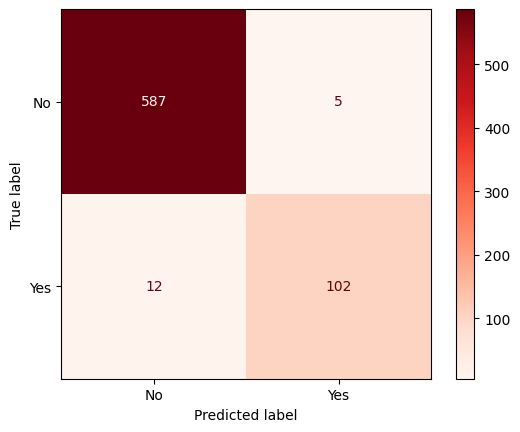

Balanced Accuracy (test) =  94.31%
Precision (test) =  95.33%
Recall (test) =  89.47%
F1 Score (test) =  92.31%


In [ ]:
# confusion matrix
y_pred = best_model.predict(X_test)
cm1 = metrics.confusion_matrix(y_test,y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ['No','Yes'])
# display matrix
cm_display.plot(cmap='Reds')
plt.show()

# Imprimo las métricas relevantes
print(f"Balanced Accuracy (test) =  {100 * balanced_accuracy_score(y_test, y_pred):.2f}%")
print(f"Precision (test) =  {100 * precision_score(y_test, y_pred, pos_label='Yes'):.2f}%")
print(f"Recall (test) =  {100 * recall_score(y_test, y_pred, pos_label='Yes'):.2f}%")
print(f"F1 Score (test) =  {100 * f1_score(y_test, y_pred, pos_label='Yes'):.2f}%")


AUC (test) = 97.42%


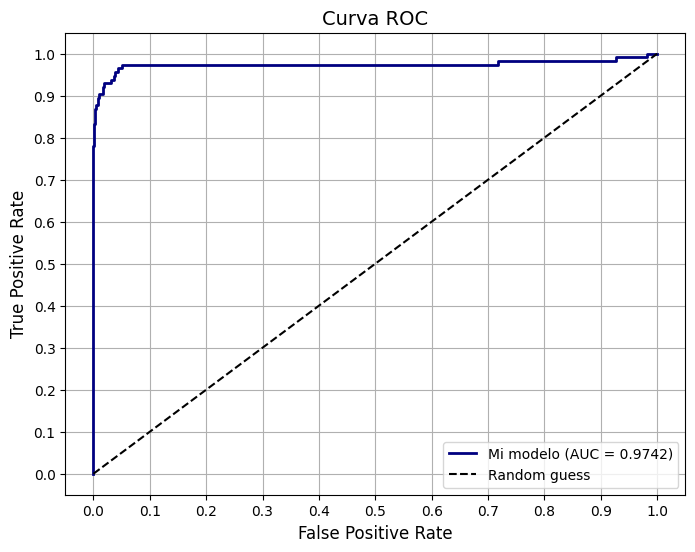

In [ ]:
# Paso las labels de la variable objetivo a formato binario para poder graficar la ROC curve
y_test_num = np.where(y_test == 'Yes', 1, 0)

# Calculo las probabilidades de Attrition = 1
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculo AUC
FPR, TPR, thresholds = roc_curve(y_test_num, y_prob)
auc = roc_auc_score(y_test_num, y_prob)
print(f"AUC (test) = {100 * auc:.2f}%")

# Grafico AUC
plt.figure(figsize=(8,6))
plt.plot(FPR, TPR, color='navy', linewidth=2, label=f'Mi modelo (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Curva ROC", fontsize=14)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.legend(loc='lower right')
plt.show()



Desde un punto de vista interpretativo, una AUC tan alta refleja que el modelo mantiene bajos niveles de falsos positivos y falsos negativos a lo largo de distintos umbrales de decisión. Esto sugiere una buena generalización sobre datos no vistos y una fuerte capacidad discriminativa.

Observando tanto las métricas provenientes de la matriz de confusión como la AUC en el test set, se puede reafirmar el buen rendimiento que muestra el modelo seleccionado en el test set, así como su capacidad de poder generalizar predicciones en datos nuevos.

In [ ]:
# Obtención del mejor modelo.
# Incluye la pipeline completa, con preprocesado.
# aca puedo elegir mas de un modelo para probar sobre validacion
#best_model = search.best_estimator_

# Entrenamiento del modelo con todas las observaciones de data_avai, es decir, las 1000.
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
best_model.fit(X, y)

# Serialización del modelo.
with open('best_model_gb.pkl', 'wb') as f:
  pkl.dump(best_model, f)

In [ ]:
# EN CASO DE SER NECESARIO SE PUEDE DESCARGAR MANUALMENTE EL MODELO AQUÍ QUITANDO LOS #
from google.colab import files
files.download("/content/best_model_gb.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Serializar el modelo es guardarlo en un archivo .pkl que tiene toda la informacion del modelo (no el modelo en si, sino del pipeline completo)

# Conclusiones
Durante este proyecto se desarrolló una solución a un problema de clasificación, puntualmente el de predecir abandono corporativo por parte de un trabajador dado. Para lograr el fin último del proyecto, fue necesaria una serie de pasos desarrollados a lo largo del documento, tales como el análisis de los datos, diseño del pipeline, separación en train y test sets, preprocesado de los datos, entrenamiento, evaluación y comparación de distintos modelos de Machine Learning orientados a problemas de clasificación. Cada una de estas etapas jugó un rol fundamental, ya que cada una actuó como engranaje para el correcto desarrollo de la siguiente.

En referencia a los modelos entrenados y evaluados, se intentó cubrir el mayor rango de modelos posibles, dentro de los que cumplían los requisitos como para ser considerados en el proyecto. La función `GridSearchCV` también fue fundamental en la búsqueda del modelo óptimo, junto con su combinación óptima de hiperparámetros, que finalmente resultó siendo el modelo basado en GradientBoosting, con los hiperparámetros descriptos anteriormente. El modelo mostró un `balanced_accuracy_score` de al 94.31% en el test set, junto con valores de `precision_score`, `recall_score` y `f1_score` de 95.33%, 89.47% y 92.31%, respectivamente, así como un Area Under the Curve (`roc_auc_score`) superior al 97%. Éstas últimas métricas representan un aspecto relevante en la evaluación del modelo, dado el claro desbalance entre clases en la variable objetivo. Por más que se haga uso de `SMOTE`, al basarse únicamente en `accuracy`, podrían omitirse errores grandes en las predicciones, pero al considerar también las otras métricas, se logra una perspectiva más certera sobre la verdadera capacidad predictiva del modelo.

Los rendimientos en las métricas mencionadas anteriormente en el test set permiten argumentar que el modelo evitó caer en overfitting y que logra generalizar sus predicciones correctamente hacia datos que nunca vio. Por otro lado, el uso de validación cruzada también contribuye al buen entrenamiento de los modelos, al evitar que los mismos memoricen los datos de entrenamiento volviéndolos débiles para generalizar hacia datos nuevos, aspecto que se evita al segmentar por folds con la función `StratifiedKFold`.

En suma, el trabajo permitió desarrollar y evaluar un amplio abanico de modelos de clasificación, optimizados mediante validación cruzada y comparados con métricas apropiadas que contemplan el desbalance de clase en la variable objetivo. Si bien los resultados obtenidos en el conjunto de validación y test interno son prometedores, el verdadero desempeño del modelo se confirmará al aplicarlo sobre el conjunto de test en la competencia, que permitirá evaluar su capacidad de generalización frente a datos completamente nuevos y, en última instancia, determinar la solidez real de las estrategias implementadas.

# Carga del modelo y uso en competición

Finalmente, cargaremos el modelo serializado (el mejor encontrado) y lo utilizaremos para realizar la predicción de los datos de la competición.

**¡Importante!**
Aquí vamos a hacer algo de trampa, porque como hemos generado los datos, podemos saber qué puntuación tendríamos en la competición. Esto es algo imposible en una competición real.

In [ ]:
# Carga del modelo.
with open('best_model_gb.pkl', 'rb') as f:
  model = pkl.load(f)

# Uso del modelo para predecir.
#y_comp_pred = model.predict(X_test)

# Guardado de los resultados de la competición (500 filas).
#pd.DataFrame(y_comp_pred).to_csv('results.csv', header=False, index=False)

# ANEXO: Prompts de IA generativa (Chatgpt)
El uso de IA generativa en este proyecto tuvo como principal foco reducir los tiempos de escritura de código y ejecución, haciendo un notebook más eficiente. A lo largo de este anexo se observará que la mayoría de los prompts fueron orientados hacia tareas iterativas, como generación de gráficos o creaciones de loops para visualizar distintos aspectos de forma iterativa.

## Prompt 1: generación de boxplots para variables numéricas
**J:** Las preguntas que te haga son orientadas a un dataset llamado train.csv, haceme un codigo que me muestre un boxplot para cada variable numerica

**Chatgpt**:


In [ ]:

import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv("train.csv")

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(6, 3))
    plt.boxplot(df[col].dropna(), vert=False)  # vert=False = horizontal
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

## Prompt 2: boxplots en formato de grilla
**J:** esto podes mostrarmelo como grilla donde haya 4 graficos por fila?

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns # Generar un boxplot para cada columna numérica for col in num_cols: plt.figure(figsize=(6, 3)) plt.boxplot(X_train[col].dropna(), vert=False) # vert=False = horizontal plt.title(f"Boxplot de {col}") plt.xlabel(col) plt.show()

**Chatgpt:**


In [ ]:
import matplotlib.pyplot as plt
import math

# Columnas numéricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Parámetros de grilla
n = len(num_cols)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
axes = axes.flatten()

# Generar boxplots
for i, col in enumerate(num_cols):
    axes[i].boxplot(X_train[col].dropna(), vert=False)
    axes[i].set_title(f"{col}", fontsize=10)
    axes[i].set_xlabel("Valor")

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Prompt 3: generación de gráficos de distribución para variables categóricas
**J:** generame gráficos de distribución para las variables categóricas

**Chatgpt:**

In [ ]:
import math

n = len(cat_cols)
rows = math.ceil(n / 3)  # 3 gráficos por fila

fig, axes = plt.subplots(rows, 3, figsize=(20, 5*rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    df[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis="x", rotation=45) # Yo después lo ajusté a 60

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Prompt 4: tabla de missing values
**J:** mostrame una tablita con las variables con missing values, su cantidad y su proporcion sobre el total

**Chatgpt:**

In [ ]:
import pandas as pd

# Calcular valores nulos por columna
missing_values = df.isnull().sum()

# Filtrar solo columnas con missing
missing_values = missing_values[missing_values > 0]

# Crear tabla con cantidad y porcentaje
missing_table = pd.DataFrame({
    'MissingCount': missing_values,
    'MissingPercent': (missing_values / len(df)) * 100
}).sort_values(by='MissingPercent', ascending=False)

print(missing_table)

# Yo después la adapte y retoqué levemente el código

## Prompt 5: heatmap de correlaciones de variables numéricas
**J:** necesito un heatmap de la media matriz de correlación de las variables numéricas

**Chatgpt:**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas y eliminar ID
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'], errors='ignore')

# Matriz de correlación
corr = num_cols.corr()

# Crear máscara para ocultar la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Matriz de correlación (triangular inferior)", fontsize=16)
plt.show()


## Prompt 6: loop for para analizar métricas de los 10 mejores modelos del GridSearchCV
**J:** en base a este código:

In [ ]:
# Obtenemos el dataframe con los resultados.
results = pd.DataFrame(search.cv_results_)

# Vamos a simplificar los nombres de las columnas.
# 1. Quitamos el texto 'classifier__'
# 2. Renombramos la columna 'param_classifier' por simplemente 'classifier'.
results.rename(columns=lambda s : s.replace('classifier__', ''), inplace=True)
results.rename(columns=lambda s : s.replace('param_classifier', 'classifier'), inplace=True)

# Vamos a quitar los parámetros del clasificador.
results['classifier'] = results.classifier.apply(lambda c : c.__class__.__name__)

# Vamos a quitar la columna 'params' por ser redundante.
results.drop(columns=['params'], inplace=True)

# Ordenamos las columnas alfabéticamente.
results = results[sorted(results)]

# Ordenamos los modelos por ranking, de mejor a peor.
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(inplace=True)

# Mostramos los resultados.
display(results.head(15))

dame un loop for que calcule accuracy, precision, recall y f1 score de los primeros 10 modelos según rank_test_score

**Chatgpt:**

In [ ]:
from sklearn.base import clone
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Ordenar resultados y tomar top 5
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
top5 = results.head(10)

for i, row in top5.iterrows():
    params = row['params']
    # Clonar pipeline y setear parámetros
    model = clone(search.best_estimator_)
    model.set_params(**params)
    model.fit(X_train, y_train)

    # Predicciones en test
    y_pred = model.predict(X_test)

    # Métricas
    acc_test = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='Yes')
    recall = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')

    print("="*60)
    print(f"Modelo rank {row['rank_test_score']} con params={params}")
    print(f"Balanced Accuracy (test): {(100*acc_test):.2f}%")
    print(f"Precision (test): {(100*precision):.2f}%")
    print(f"Recall (test): {(100*recall):.2f}%")
    print(f"F1 Score (test): {(100*f1):.2f}%")

## Prompt 7: reescribir Pipeline asegurándome que el clasificador seleccionado es el mejor GradientBoosting
**J:** reescribime el pipeline pero seteando como clasificador el mejor modelo GradientBoosting de la tabla de results

**Chatgpt:**

In [ ]:
from sklearn.base import clone

# Clonamos el pipeline original
best_model = clone(ml_pipe)

# Seteamos los parámetros del KNN
best_model.set_params(
    classifier= GradientBoostingClassifier(random_state=42),
    classifier__learning_rate= 0.2,
    classifier__max_depth= 5,
    classifier__n_estimators= 500
)

# Entrenamos el modelo sobre X_train, y_train
best_model.fit(X_train, y_train)

## Prompt 8: graficar histogramas de variables numéricas discriminando por `Attrition`
**J:** reescribime este código pero discriminando por la clase de la variable Attrition df.hist(bins=10, figsize=(20,15)) plt.show()

**Chatgpt:**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar solo las columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Crear figura grande
fig, axes = plt.subplots(nrows=len(numeric_cols)//3 + 1, ncols=3, figsize=(20, 15))
axes = axes.flatten()

# Colores para cada clase de Attrition
colors = {'Yes': 'orange', 'No': 'steelblue'}

# Generar histogramas por variable
for i, col in enumerate(numeric_cols):
    for attrition_class, color in colors.items():
        df[df['Attrition'] == attrition_class][col].hist(
            bins=15,
            alpha=0.6,
            ax=axes[i],
            color=color,
            label=attrition_class
        )
    axes[i].set_title(col, fontsize=12)
    axes[i].legend()

# Eliminar ejes vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Prompt 9: graficar histogramas de variables categóricas discriminando por `Attrition`
**J:** repetí lo que te pedí pero para variables categóricas

**Chatgpt:**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Detectar variables categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns

n = len(cat_cols)
rows = math.ceil(n / 3)  # 3 gráficos por fila

fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))
axes = axes.flatten()

# Colores por clase
colors = {'Yes': 'darkorange', 'No': 'steelblue'}

for i, col in enumerate(cat_cols):
    # Crear tabla de frecuencias cruzadas normalizadas
    counts = pd.crosstab(df[col], df['Attrition'])

    # Ordenar por frecuencia total (opcional, ayuda a visualizar)
    counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

    # Graficar barras lado a lado
    counts.plot(kind='bar', ax=axes[i], color=colors.values(), alpha=0.8)

    axes[i].set_title(f"Distribución de {col} por Attrition", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].tick_params(axis='x', rotation=60)
    axes[i].legend(title='Attrition')

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Prompt 10: generación de requirements.txt
**J:** generame un documento de requirements.txt de este archivo

**Chatgpt:**

In [ ]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Bibliografía y material de referencia
- Hands-On Machine Learning with Scikit-Learn & TensorFlow (Aurélien Géron, 2017)
- An Introduction to Statistical Learning with Applications in Python (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, Jonathan Taylor, 2023)
- Notebook publicado en Aula Global, titulado *End-to-End ML Pipeline v2.ipynb*
- Slides del curso y otros materiales publicados en Aula Global
- Documentación de sklearn para aprendizaje supervisado: https://scikit-learn.org/stable/supervised_learning.html
- Documentación de seaborn: https://seaborn.pydata.org/
- Documentación de matplotlib: https://matplotlib.org/stable/index.html